# Projeto: *Music Generation*
* Geração da próxima nota musical.
* Neste exemplo, utilizaremos alguns dos *Chorais de Bach* para gerar músicas. Os chorais são uma parte importante da música sacra de Bach e são frequentemente encontrados em suas obras corais, como as cantatas, os oratórios e a Paixão de São Mateus. Os chorais de Bach são caracterizados por suas melodias ricas e harmonias sofisticadas, e muitos deles se tornaram amplamente conhecidos e apreciados até hoje.

Para essa aplicação, utilizaremos um [conjunto de dados](https://drive.google.com/drive/folders/1dKOdOhmcijZhoZEYwDJ-to3O4jAfiiD_?usp=sharing) contendo alguns dos Corais de Bach.

Este conjunto é composto por 382 corais.

Cada coral tem entre 100 e 640 passos de tempo e cada passo de tempo contém 4 inteiros, onde cada inteiro corresponde ao índice de uma nota em um piano (exceto pelo valor 0, que significa que nenhuma nota é tocada).

Treine um modelo - recorrente, convolucional ou ambos - que possa prever o próximo passo de tempo (quatro notas), dado uma sequência de passos de tempo de um coral.

Em seguida, use esse modelo para gerar música semelhante a Bach, uma nota de cada vez: você pode fazer isso fornecendo ao modelo o início de um coral e pedindo para ele prever o próximo passo de tempo, em seguida, acrescentando esses passos de tempo à sequência de entrada e pedindo ao modelo pela próxima nota, e assim por diante.

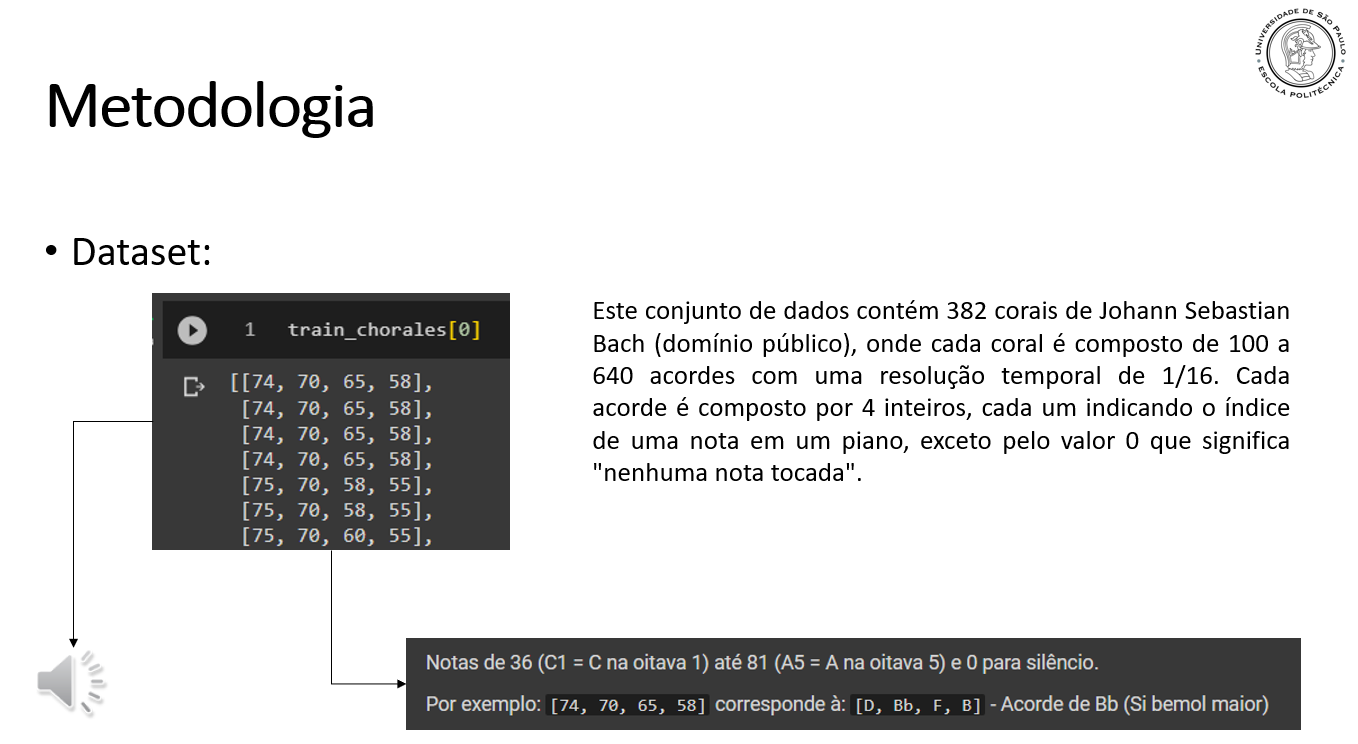

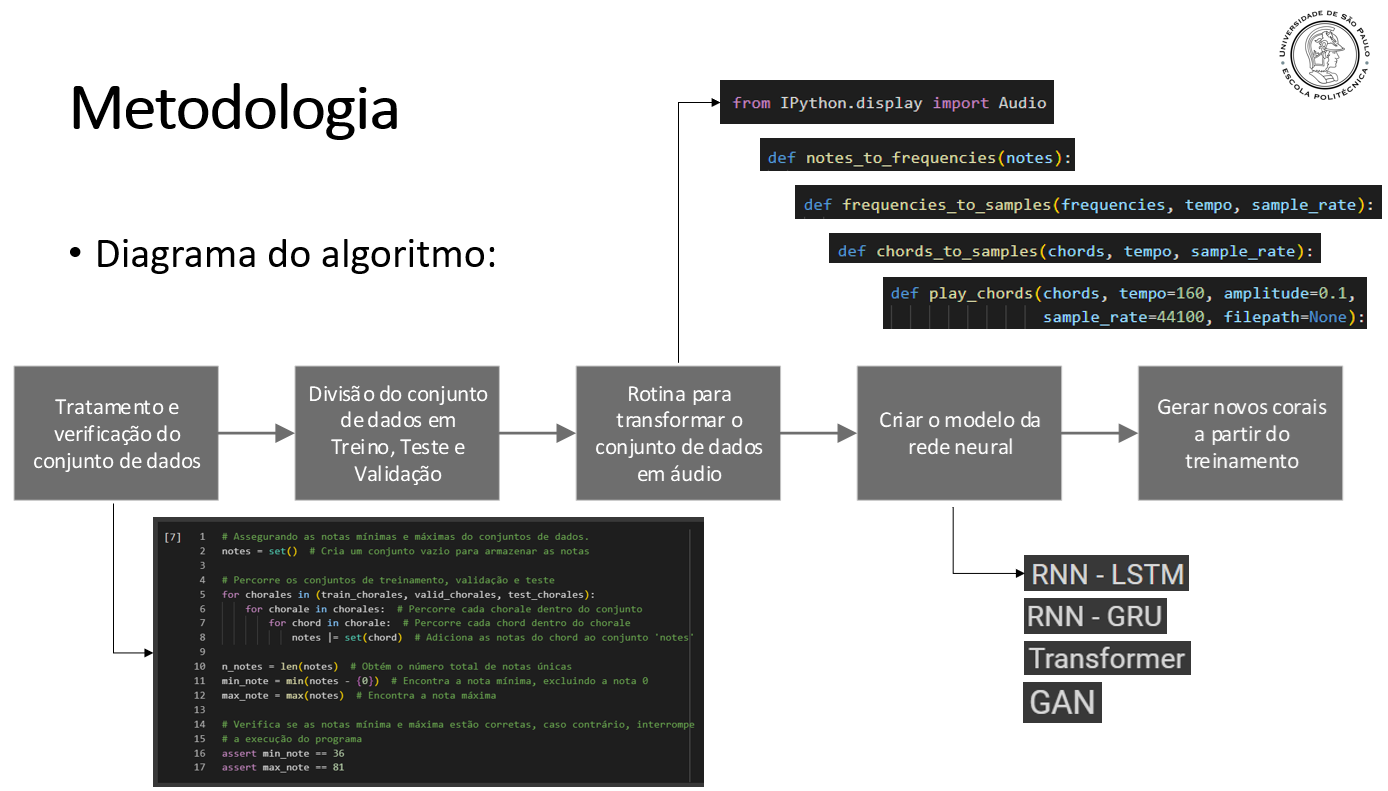

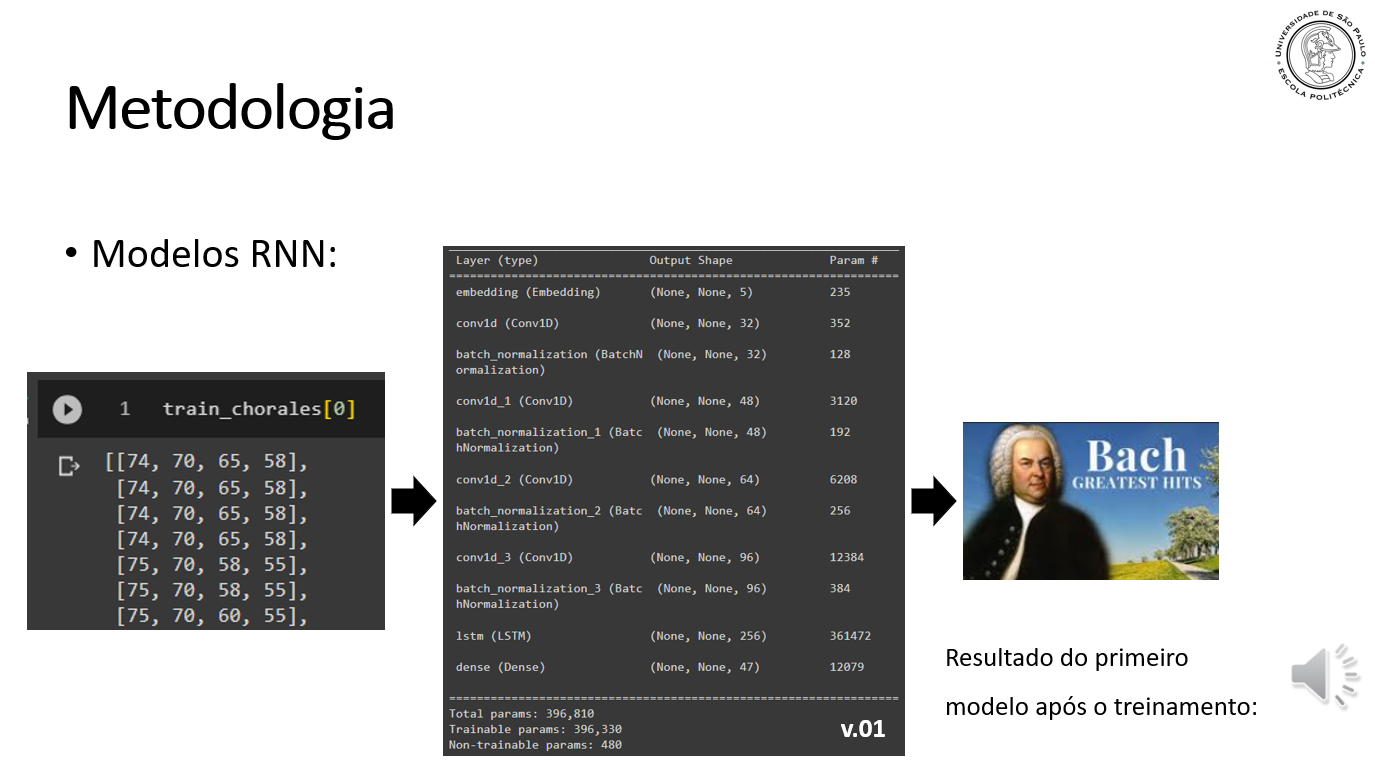

# Setup Python

In [1]:
# Python ≥3.5 - requerido
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Imports comuns
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path

# Estabilizar e padronizar as respostas deste notebook.
np.random.seed(42)
tf.random.set_seed(42)

# Para confgurar a não exibição de mensagens durante a compilação verbose=0
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

# Dataset contendo os chorais de Bach

In [2]:
# Acessando e baixando os arquivos
DOWNLOAD_ROOT = "https://tinyurl.com/2d2ammnn/"
FILENAME = "jsb_chorales.tgz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/jsb_chorales",
                                extract=True)

117661/117661 [==============================] - 0s 0us/step


In [3]:
# Obtém o diretório pai do caminho de arquivo especificado
jsb_chorales_dir = Path(filepath).parent

# Encontra todos os arquivos que correspondem ao padrão "train/chorale_*.csv" no diretório
train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))

# Encontra todos os arquivos que correspondem ao padrão "valid/chorale_*.csv" no diretório
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))

# Encontra todos os arquivos que correspondem ao padrão "test/chorale_*.csv" no diretório
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

In [4]:
print(train_files)

[PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_000.csv'), PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_001.csv'), PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_002.csv'), PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_003.csv'), PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_004.csv'), PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_005.csv'), PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_006.csv'), PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_007.csv'), PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_008.csv'), PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_009.csv'), PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_010.csv'), PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_011.csv'), PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_012.csv'), PosixPath('/root/.keras/datasets/jsb_chorales/train/chorale_013.csv'), Posix

In [5]:
import pandas as pd

def load_chorales(filepaths):
    # Carrega cada arquivo CSV em filepaths usando o pandas e converte o conteúdo para uma lista de listas
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

# Carrega os dados dos arquivos de treinamento usando a função load_chorales
train_chorales = load_chorales(train_files)

# Carrega os dados dos arquivos de validação usando a função load_chorales
valid_chorales = load_chorales(valid_files)

# Carrega os dados dos arquivos de teste usando a função load_chorales
test_chorales = load_chorales(test_files)

In [6]:
train_chorales[0]

[[74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [75, 70, 58, 55],
 [75, 70, 58, 55],
 [75, 70, 60, 55],
 [75, 70, 60, 55],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 70, 62, 55],
 [77, 70, 62, 55],
 [77, 69, 62, 55],
 [77, 69, 62, 55],
 [75, 67, 63, 48],
 [75, 67, 63, 48],
 [75, 69, 63, 48],
 [75, 69, 63, 48],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [75, 69, 63, 48],
 [75, 69, 63, 48],
 [75, 67, 63, 48],
 [75, 67, 63, 48],
 [77, 65, 62, 50],
 [77, 65, 62, 50],
 [77, 65, 60, 50],
 [77, 65, 60, 50],
 [74, 67, 58, 55],
 [74, 67, 58, 55],
 [74, 67, 58, 53],
 [74, 67, 58, 53],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 65, 57

Notas de 36 (C1 = C na oitava 1) até 81 (A5 = A na oitava 5) e 0 para
silêncio.

Por exemplo: `[74, 70, 65, 58]` corresponde à: `[D, Bb, F, B]` - Acorde de Bb (Si bemol maior)

In [7]:
# Assegurando as notas mínimas e máximas do conjuntos de dados.
notes = set()  # Cria um conjunto vazio para armazenar as notas

# Percorre os conjuntos de treinamento, validação e teste
for chorales in (train_chorales, valid_chorales, test_chorales):
    for chorale in chorales:  # Percorre cada chorale dentro do conjunto
        for chord in chorale:  # Percorre cada chord dentro do chorale
            notes |= set(chord)  # Adiciona as notas do chord ao conjunto 'notes'

n_notes = len(notes)  # Obtém o número total de notas únicas
min_note = min(notes - {0})  # Encontra a nota mínima, excluindo a nota 0
max_note = max(notes)  # Encontra a nota máxima

# Verifica se as notas mínima e máxima estão corretas, caso contrário, interrompe
# a execução do programa
assert min_note == 36
assert max_note == 81

Neste código, um conjunto vazio chamado `notes` é criado para armazenar as notas encontradas nos dados musicais. Em seguida, um loop é realizado sobre os conjuntos de treinamento, validação e teste. Dentro de cada conjunto, são percorridos os chorales e, em seguida, os chords de cada chorale. As notas de cada chord são adicionadas ao conjunto `notes` usando a operação de união (`|=`).

Após o loop, o número total de notas únicas é obtido através do comprimento do conjunto `notes` armazenado na variável `n_notes`. A nota mínima é encontrada usando a função `min`, excluindo a nota 0 do conjunto `notes - {0}` e armazenada na variável `min_note`. A nota máxima é encontrada usando a função `max` no conjunto `notes` e armazenada na variável `max_note`.

Em seguida, o código verifica se as notas mínima e máxima estão corretas usando as declarações assert. Se as verificações falharem, será lançada uma exceção para indicar que algo está errado. Neste caso, o código verifica se `min_note` é igual a 36 e se `max_note` é igual a 81.

# Ouvindo o Dataset

Vamos escrever algumas funções para ouvir esses chorais escrevendo um sintetizador para traduzir o dataset em audio.

In [8]:
from IPython.display import Audio

In [9]:
def notes_to_frequencies(notes):
    # A frequência dobra ao subir uma oitava; existem 12 semitons em cada oitava;
    # A nota A na oitava 3 é 440 Hz, e ela corresponde ao número 69.
    return 2 ** ((np.array(notes) - 69) / 12) * 440

Esse código define a função `notes_to_frequencies` que converte números de notas musicais em suas respectivas frequências em hertz.

A função recebe como entrada um array ou lista de números de notas, onde cada número representa uma nota musical. O código então realiza o seguinte cálculo para converter cada número de nota em sua frequência correspondente:

* Subtrai 69 de cada número de nota para normalizar a escala. Isso é feito porque o número 69 corresponde à nota A na oitava 3, que possui uma frequência de 440 Hz.

* Divide o resultado anterior por 12 para obter a diferença em semitons em relação à nota A na oitava 3.

* Calcula 2 elevado ao valor obtido no passo anterior. Isso é feito porque a frequência dobra a cada oitava (que tem 12 semitons) ao subir uma oitava.

* Multiplica o resultado do passo anterior por 440, que é a frequência da nota A na oitava 3.

O resultado final é um array ou lista com as frequências correspondentes às notas musicais fornecidas. Essas frequências indicam a quantidade de oscilações por segundo para cada nota, e são usadas para gerar sons musicais com as notas específicas.

In [10]:
def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo  # o tempo é medido em batidas por minuto
    # Para reduzir o som de clique a cada batida, arredondamos as frequências para tentar
    # obter as amostras próximas de zero no final de cada nota.
    frequencies = np.round(note_duration * frequencies) / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    # Removendo todas as notas com frequências ≤ 9 Hz (inclui a nota 0 = silêncio)
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

Esse código define a função `frequencies_to_samples` que converte frequências em amostras de áudio.

A função recebe três argumentos:

* `frequencies`: uma lista ou array contendo as frequências das notas musicais.
* `tempo`: o tempo em batidas por minuto.
* `sample_rate`: a taxa de amostragem, ou seja, o número de amostras de áudio por segundo.
O código realiza as seguintes etapas para converter as frequências em amostras de áudio:

* Calcula a duração de uma nota, dividindo 60 pelo tempo em batidas por minuto. Isso fornece a duração de cada nota em segundos.

* Arredonda as frequências multiplicadas pela duração da nota para tentar obter amostras próximas de zero no final de cada nota. Isso é feito para reduzir o som de clique que pode ocorrer quando há uma mudança abrupta de frequência entre as notas.

* Calcula o número de amostras necessário para representar a duração da nota, multiplicando a duração da nota pelo sample_rate.

* Cria um array chamado time que representa o tempo para cada amostra de áudio. Esse array é criado usando `np.linspace` para gerar valores igualmente espaçados de 0 a duração da nota.

* Calcula formas de onda senoidais (`sine_waves`) multiplicando as frequências pelas amostras de tempo e pelas constantes relacionadas a 2π. Isso cria uma forma de onda para cada frequência.

* Multiplica as formas de onda senoidais pelo resultado da comparação entre as frequências e 9. Essa comparação cria um array booleano indicando quais frequências são maiores que 9 Hz. Isso é feito para remover as notas com frequências muito baixas, incluindo a nota 0, que representa o silêncio.

* Retorna as formas de onda senoidais resultantes como um array unidimensional.

Em resumo, essa função gera amostras de áudio a partir das frequências das notas musicais. As amostras representam formas de onda senoidais para cada nota, com ajustes para evitar cliques e remover notas de frequência muito baixa. Essas amostras podem ser usadas para reproduzir as notas musicais com as frequências correspondentes.

In [11]:
def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = np.r_[freqs, freqs[-1:]]  # faz a última nota um pouco mais longa
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate)
                     for melody in freqs.T], axis=0)
    n_fade_out_samples = sample_rate * 60 // tempo  # fade out na última nota
    fade_out = np.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

Esse código define a função `chords_to_samples` que converte acordes musicais em amostras de áudio.

A função recebe três argumentos:

* `chords`: uma lista ou array contendo os acordes musicais representados como números de notas.
* `tempo`: o tempo em batidas por minuto.
* `sample_rate`: a taxa de amostragem, ou seja, o número de amostras de áudio por segundo.
O código realiza as seguintes etapas para converter os acordes em amostras de áudio:

* Chama a função `notes_to_frequencies` para converter os números de notas dos acordes em suas respectivas frequências.

* Adiciona a última frequência duplicada na lista de frequências. Isso faz com que a última nota do acorde seja um pouco mais longa em relação às outras.

* Usa uma compreensão de lista para chamar a função `frequencies_to_samples` para cada melodia (conjunto de frequências) na transposta das frequências. A função `frequencies_to_samples` gera amostras de áudio para cada melodia com base no tempo e taxa de amostragem fornecidos.

* Calcula a duração do fade-out na última nota, multiplicando a taxa de amostragem pelo número de segundos em um minuto dividido pelo tempo. Isso determina quantas amostras serão usadas para criar o fade-out.

* Cria um array chamado `fade_out` que contém uma sequência de valores de intensidade decrescentes, variando de 1 a 0. Esses valores são usados para aplicar um efeito de fade-out na última nota.

* Multiplica as amostras da última nota pelo array `fade_out`, fazendo com que a intensidade das amostras diminua gradualmente.

* Calcula a média das amostras de áudio de todas as melodias dos acordes usando `np.mean` ao longo do eixo 0. Isso cria um único conjunto de amostras de áudio que representa todos os acordes.

* Retorna as amostras de áudio resultantes como um array unificado.

Em resumo, essa função converte acordes musicais em amostras de áudio que podem ser reproduzidas para ouvir os acordes em forma de som.

In [12]:
def play_chords(chords, tempo=160, amplitude=0.1,
                sample_rate=44100, filepath=None):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    if filepath:
        from scipy.io import wavfile
        samples = (2**15 * samples).astype(np.int16)
        wavfile.write(filepath, sample_rate, samples)
        return display(Audio(filepath))
    else:
        return display(Audio(samples, rate=sample_rate))

Esse código define a função `play_chords` que reproduz acordes musicais.

A função recebe vários argumentos opcionais:

* `chords`: uma lista ou array contendo os acordes musicais representados como números de notas.
* `tempo`: o tempo em batidas por minuto (padrão: 160).
* `amplitude`: a amplitude do som dos acordes (padrão: 0.1).
* `sample_rate`: a taxa de amostragem, ou seja, o número de amostras de áudio por segundo (padrão: 44100).
* `filepath`: o caminho do arquivo WAV para salvar o áudio (opcional).
O código realiza as seguintes etapas:

* Chama a função `chords_to_samples` para converter os acordes em amostras de áudio, com base nos parâmetros fornecidos (tempo, taxa de amostragem).

* Multiplica as amostras de áudio pelo valor da amplitude para controlar o volume do som dos acordes.

* Se um caminho de arquivo (`filepath`) for fornecido, o código salva as amostras de áudio em um arquivo WAV usando a biblioteca `scipy.io.wavfile`.

* Se um caminho de arquivo foi fornecido, a função retorna `display(Audio(filepath))`, que exibe um player de áudio no ambiente em que o código está sendo executado, permitindo a reprodução do áudio a partir do arquivo.

* Se nenhum caminho de arquivo foi fornecido, a função retorna `display(Audio(samples, rate=sample_rate))`, que exibe um player de áudio com base nas amostras de áudio geradas, permitindo a reprodução direta do áudio.

Em resumo, essa função reproduz acordes musicais, convertendo-os em amostras de áudio e permitindo a reprodução do áudio gerado. O áudio pode ser reproduzido diretamente ou salvo em um arquivo WAV, dependendo dos parâmetros fornecidos.

Portanto, em linhas gerais, nessas funções temos as funções fornecem utilidades relacionadas à geração e reprodução de notas e acordes musicais. Cada função possui um comentário explicando sua finalidade.

* A função `notes_to_frequencies` converte números de notas em suas respectivas frequências em hertz.

* A função `frequencies_to_samples` gera formas de onda senoidais com base nas frequências, duração das notas e taxa de amostragem especificadas.

* A função `chords_to_samples` mescla várias melodias de acordes em uma única amostra de áudio.

* A função `play_chords` reproduz os acordes gerados, podendo salvar o áudio em um arquivo WAV se o caminho do arquivo for fornecido.

Lembrando que esse código faz uso de bibliotecas como `numpy`, `IPython.display` e `scipy.io` para manipulação de áudio e cálculos musicais.

In [ ]:
for index in range(3):
    play_chords(train_chorales[index])

Output hidden; open in https://colab.research.google.com to view.

Salvando exemplo para apresentação:

In [13]:
play_chords(train_chorales[0], filepath="train_chorales_0.wav")

Output hidden; open in https://colab.research.google.com to view.

A fim de ser capaz de gerar novos chorais, queremos treinar um modelo que possa prever o próximo acorde dado todos os acordes anteriores. Se tentarmos ingenuamente prever o próximo acorde de uma vez, prevendo todas as 4 notas de uma só vez, corremos o risco de obter notas que não combinam muito bem juntas (a não ser que você seja um conhecedor e especialista em harmonia musical!).
Assim, é muito melhor e mais simples prever uma nota de cada vez.

Portanto, precisaremos pré-processar cada coral, transformando cada acorde em um arpejo (ou seja, uma sequência de notas em vez de notas tocadas simultaneamente).

Assim, cada coral será uma longa sequência de notas (em vez de acordes), e podemos simplesmente treinar um modelo que possa prever a próxima nota dado todas as notas anteriores. Usaremos uma abordagem de sequência para sequência, onde alimentamos uma janela para a rede neural e ela tenta prever essa mesma janela deslocada um passo de tempo para o futuro.

Também iremos ajustar os valores para que eles variem de 0 a 46, onde 0 representa silêncio, e os valores de 1 a 46 representam as notas de 36 (C1 - Dó1) a 81 (A5 - Lá5).

E treinaremos o modelo em janelas de 128 notas (ou seja, 32 acordes).

Como o conjunto de dados cabe na memória, poderíamos pré-processar os corais na RAM usando qualquer código Python que desejarmos.

In [14]:
def create_target(batch):
    X = batch[:, :-1]
    Y = batch[:, 1:]  # prever a próxima nota em cada arpejo, em cada passo
    return X, Y

def preprocess(window):
    window = tf.where(window == 0, window, window - min_note + 1)  # deslocar valores
    return tf.reshape(window, [-1])  # converter para arpejo

def bach_dataset(chorales, batch_size=32, shuffle_buffer_size=None,
                 window_size=32, window_shift=16, cache=True):
    def batch_window(window):
        return window.batch(window_size + 1)

    def to_windows(chorale):
        dataset = tf.data.Dataset.from_tensor_slices(chorale)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder=True)
        return dataset.flat_map(batch_window)

    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.flat_map(to_windows).map(preprocess)

    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(create_target)
    return dataset.prefetch(1)

Neste código, são definidas várias funções para pré-processar e criar um conjunto de dados (dataset) a partir dos chorais de Bach:

* A função `create_target` recebe um lote (batch) de dados e retorna as entradas `X` e os alvos `Y`. A entrada `X` é formada pelos primeiros elementos de cada sequência no lote, e os alvos `Y` são formados pelos elementos seguintes em cada sequência.

* A função `preprocess` recebe uma janela de dados e realiza o pré-processamento necessário. Ela faz um deslocamento nos valores da janela, subtraindo o valor mínimo (`min_note`) e adicionando 1. Em seguida, a janela é convertida em um arpejo (uma sequência linearizada) por meio da função `tf.reshape`.

* A função `bach_dataset` recebe os chorais de Bach e os parâmetros relacionados à criação do conjunto de dados. Ela cria janelas deslizantes a partir dos chorais, utilizando o tamanho da janela e o deslocamento especificados. Os chorais são convertidos em um formato apropriado (`tf.ragged.constant`) e, em seguida, o conjunto de dados é construído por meio de uma sequência de operações. O conjunto de dados resultante é pré-processado com a função `preprocess`, podendo ser armazenado em cache (se o parâmetro cache for True) e embaralhado (se o parâmetro `shuffle_buffer_size` for especificado). Em seguida, o conjunto de dados é agrupado em lotes, mapeado para criar os pares de entrada e alvo com a função `create_target` e, finalmente, pré-carregado em memória com `prefetch`.

Essa função `bach_dataset` é útil para criar um conjunto de dados a partir dos chorais de Bach, a fim de treinar um modelo de aprendizado de máquina capaz de prever as próximas notas musicais com base nas notas anteriores.

# Criação do conjunto de treino, teste e validação

In [15]:
train_set = bach_dataset(train_chorales, shuffle_buffer_size=1000)
valid_set = bach_dataset(valid_chorales)
test_set = bach_dataset(test_chorales)

* `train_set = bach_dataset(train_chorales, shuffle_buffer_size=1000)`: Cria um conjunto de dados de treinamento utilizando a função `bach_dataset`. É passado como argumento `train_chorales`, que representa os corais de treinamento. Além disso, é especificado `shuffle_buffer_size=1000`, que define o tamanho do buffer de embaralhamento utilizado durante o treinamento. Isso implica que os dados de treinamento serão embaralhados aleatoriamente durante o treinamento do modelo.

* `valid_set = bach_dataset(valid_chorales)`: Cria um conjunto de dados de validação utilizando a função `bach_dataset`. É passado como argumento `valid_chorales`, que representa os corais de validação. Nesse caso, não é especificado um tamanho de buffer de embaralhamento, portanto, não haverá embaralhamento dos dados de validação durante o treinamento.

* `test_set = bach_dataset(test_chorales)`: Cria um conjunto de dados de teste utilizando a função bach_dataset. É passado como argumento test_chorales, que representa os corais de teste. Da mesma forma que o conjunto de validação, não é especificado um tamanho de buffer de embaralhamento para os dados de teste.

# Criação de modelos

## Criando o modelo - RNN - LSTM v.01

* Poderíamos alimentar os valores das notas diretamente para o modelo, como floats, mas isso provavelmente não resultaria em bons resultados. De fato, as relações entre as notas não são tão simples assim: por exemplo, se substituirmos um Dó3 por um Dó4, a melodia ainda soará bem, mesmo que essas notas estejam separadas por 12 semitons (ou seja, uma oitava). Por outro lado, se substituirmos um Dó3 por um Dó#3, é muito provável que o acorde soe horrível, apesar dessas notas estarem próximas uma da outra. Portanto, vamos usar uma camada de Embedding para converter cada nota em uma representação vetorial pequena. Vamos usar embeddings de 5 dimensões, então a saída dessa primeira camada terá formato [tamanho_lote, tamanho_janela, 5].
* Em seguida, vamos alimentar esses dados em uma pequena rede neural do tipo WaveNet, composta por uma sequência de 4 camadas Conv1D com taxas de dilatação em duplicação. Vamos intercalar essas camadas com camadas de BatchNormalization para uma convergência mais rápida e melhor.
* Em seguida, uma camada LSTM para tentar capturar padrões de longo prazo.
* E, por fim, uma camada Dense para produzir as probabilidades finais das notas. Ela vai prever uma probabilidade para cada choral no lote, para cada passo de tempo, e para cada possível nota (incluindo o silêncio). Portanto, o formato de saída será [tamanho_lote, tamanho_janela, 47].

In [16]:
n_embedding_dims = 5
# Define o número de dimensões de incorporação para a camada de incorporação

model_v01 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
    # Adiciona uma camada de incorporação que mapeia índices de notas para vetores de tamanho n_embedding_dims.
    # O número de índices possíveis é definido por n_notes.
    # A dimensão de entrada da camada é [None], indicando uma sequência de entrada de comprimento variável.

    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    # Adiciona uma camada de convolução 1D com 32 filtros e tamanho de kernel 2.
    # A opção padding="causal" aplica preenchimento apenas no lado esquerdo da sequência, preservando a ordem temporal.
    # A ativação ReLU é usada e, em seguida, uma camada de normalização em lote (Batch Normalization) é adicionada.

    keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    # Adiciona outra camada de convolução 1D com 48 filtros, tamanho de kernel 2 e taxa de dilatação 2.
    # A taxa de dilatação permite capturar dependências mais distantes na sequência.
    # A ativação ReLU é usada e, em seguida, uma camada de normalização em lote é adicionada.

    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    # Adiciona mais uma camada de convolução 1D com 64 filtros, tamanho de kernel 2 e taxa de dilatação 4.
    # Utiliza ativação ReLU e normalização em lote.

    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    # Adiciona uma última camada de convolução 1D com 96 filtros, tamanho de kernel 2 e taxa de dilatação 8.
    # Utiliza ativação ReLU e normalização em lote.

    keras.layers.LSTM(256, return_sequences=True),
    # Adiciona uma camada de célula LSTM com 256 unidades.
    # A opção return_sequences=True faz com que a camada retorne a sequência completa em vez do último estado oculto.

    keras.layers.Dense(n_notes, activation="softmax")
    # Adiciona uma camada densa com o mesmo número de unidades que o número de notas possíveis.
    # A ativação softmax é usada para obter probabilidades de distribuição para cada nota.
])

model_v01.summary()
# Exibe um resumo do modelo, mostrando a arquitetura da rede neural com o número de parâmetros e dimensões em cada camada.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 5)           235       
                                                                 
 conv1d (Conv1D)             (None, None, 32)          352       
                                                                 
 batch_normalization (BatchN  (None, None, 32)         128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, None, 48)          3120      
                                                                 
 batch_normalization_1 (Batc  (None, None, 48)         192       
 hNormalization)                                                 
                                                                 
 conv1d_2 (Conv1D)           (None, None, 64)          6

**Obs:**

Uma camada de incorporação (Embedding Layer) é uma camada em uma rede neural que mapeia índices inteiros para vetores de valores contínuos de dimensão menor. Ela é frequentemente usada para representar dados categóricos ou discretos, como palavras em um texto ou notas musicais.

A camada de incorporação é inicializada com uma matriz de pesos que é aprendida durante o treinamento do modelo. Cada índice inteiro é mapeado para um vetor de números reais de tamanho especificado, conhecido como dimensão de incorporação. Esses vetores de incorporação capturam a semântica e as relações entre os índices, permitindo que o modelo aprenda representações densas e distribuídas dos dados.

Por exemplo, em um problema de processamento de texto, onde as palavras são representadas por índices inteiros, uma camada de incorporação pode mapear cada índice de palavra para um vetor de incorporação que representa a semântica da palavra. Palavras semanticamente relacionadas tendem a ter vetores de incorporação próximos no espaço de incorporação.

Essa representação de baixa dimensão e densa fornecida pela camada de incorporação ajuda a reduzir a dimensionalidade dos dados e capturar características importantes dos índices de entrada. Além disso, ela permite que o modelo generalize para índices não vistos durante o treinamento, aprendendo uma representação densa para palavras ou outras categorias discretas.

No contexto do código fornecido, a camada de incorporação é usada para mapear índices de notas musicais para vetores de incorporação de tamanho `n_embedding_dims`. Isso permite que o modelo aprenda representações de notas musicais em um espaço de incorporação de dimensão reduzida, capturando características relevantes para o problema de previsão de notas musicais.

### Treinando o modelo

In [17]:
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
# Cria um otimizador Nadam com uma taxa de aprendizagem de 1e-3.
# O Nadam é um otimizador baseado no algoritmo Adam com Nesterov momentum.

model_v01.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# Compila o modelo com a função de perda "sparse_categorical_crossentropy",
# que é adequada para problemas de classificação com várias classes.
# Utiliza o otimizador definido anteriormente e define a métrica de avaliação como "accuracy" (acurácia),
# que mede a precisão do modelo durante o treinamento.

history_v01 = model_v01.fit(train_set, epochs=20, validation_data=valid_set)
# Realiza o treinamento do modelo com o conjunto de treinamento `train_set` por 20 épocas.
# O conjunto de validação `valid_set` é utilizado para avaliar o desempenho do modelo após cada época de treinamento.
# Durante o treinamento, o modelo tenta minimizar a função de perda especificada usando o otimizador definido.

Epoch 1/20
98/98 [==============================] - 23s 48ms/step - loss: 1.9172 - accuracy: 0.5184 - val_loss: 3.8268 - val_accuracy: 0.0248
Epoch 2/20
98/98 [==============================] - 2s 16ms/step - loss: 0.8845 - accuracy: 0.7661 - val_loss: 3.6093 - val_accuracy: 0.0836
Epoch 3/20
98/98 [==============================] - 2s 18ms/step - loss: 0.7325 - accuracy: 0.7952 - val_loss: 3.3200 - val_accuracy: 0.1207
Epoch 4/20
98/98 [==============================] - 2s 16ms/step - loss: 0.6544 - accuracy: 0.8113 - val_loss: 2.7169 - val_accuracy: 0.2475
Epoch 5/20
98/98 [==============================] - 2s 18ms/step - loss: 0.6008 - accuracy: 0.8231 - val_loss: 1.8246 - val_accuracy: 0.4571
Epoch 6/20
98/98 [==============================] - 2s 16ms/step - loss: 0.5610 - accuracy: 0.8325 - val_loss: 1.1739 - val_accuracy: 0.6440
Epoch 7/20
98/98 [==============================] - 2s 18ms/step - loss: 0.5246 - accuracy: 0.8416 - val_loss: 0.6821 - val_accuracy: 0.8023
Epoch 8/20
9

### Salvando o modelo

In [18]:
model_v01.save("my_bach_model_v01.h5")
model_v01.evaluate(test_set)

34/34 [==============================] - 0s 13ms/step - loss: 0.6807 - accuracy: 0.8130


[0.6807074546813965, 0.8129734992980957]

* `model.save("my_bach_model.h5")`: Salva o modelo treinado em um arquivo com o nome "my_bach_model.h5". O formato ".h5" é comumente usado para salvar modelos treinados em frameworks como o TensorFlow e o Keras. O modelo é salvo em disco para que possa ser carregado e reutilizado posteriormente sem precisar treiná-lo novamente.

* `model.evaluate(test_set)`: Avalia o desempenho do modelo no conjunto de teste. O `test_set` refere-se ao conjunto de dados de teste que foi separado anteriormente. A função `evaluate` executa a inferência do modelo nos dados de teste e calcula as métricas de desempenho, como a precisão, a perda ou outras métricas relevantes, dependendo do problema. Isso permite avaliar o quão bem o modelo generaliza para novos dados e medir a sua performance.

**Observação:** Não há uma necessidade real de um conjunto de teste neste exercício, uma vez que faremos a avaliação final apenas ouvindo a música produzida pelo modelo. Portanto, se desejar, você pode adicionar o conjunto de teste ao conjunto de treinamento e treinar o modelo novamente, esperando obter um modelo um pouco melhor.

Agora vamos escrever uma função que irá gerar um novo coral. Daremos a ela alguns acordes iniciais, ela os converterá em arpejos (o formato esperado pelo modelo) e usará o modelo para prever a próxima nota, depois a próxima, e assim por diante. No final, ela agrupará as notas em conjuntos de 4 para criar acordes novamente e retornará o coral resultante.

Aviso: `model.predict_classes(X)` está obsoleto. Ele foi substituído por `np.argmax(model.predict(X), axis=-1)`.

### Visualizando o treinamento

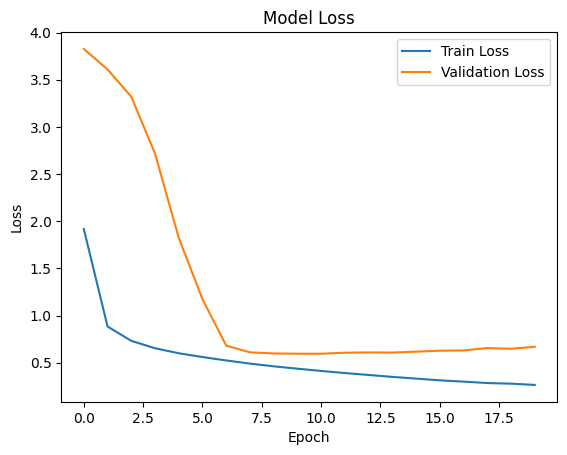

In [19]:
plt.plot(history_v01.history['loss'], label='Train Loss')
plt.plot(history_v01.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Gerando um novo coral

In [20]:
def generate_chorale(model, seed_chords, length):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))  # Pré-processa os acordes iniciais para obter o arpejo
    arpegio = tf.reshape(arpegio, [1, -1])  # Redimensiona o arpejo para ter formato [1, comprimento]
    for chord in range(length):  # Loop para gerar acordes adicionais
        for note in range(4):  # Loop para gerar cada nota do acorde
            # Próxima nota com base nas previsões do modelo
            next_note = np.argmax(model.predict(arpegio, verbose=0), axis=-1)[:1, -1:]
            arpegio = tf.concat([arpegio, next_note], axis=1)  # Concatena a próxima nota ao arpejo
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)  # Ajusta os valores do arpejo
    return tf.reshape(arpegio, shape=[-1, 4])  # Redimensiona o arpejo para ter formato de acordes

Neste código, a função `generate_chorale` recebe um modelo treinado, uma lista de acordes iniciais (`seed_chords`) e o comprimento desejado para o coral resultante (`length`).

* Primeiro, os acordes iniciais são pré-processados para obter o arpejo correspondente usando a função preprocess. Os acordes iniciais são convertidos em arpejo, que é o formato esperado pelo modelo.

* Em seguida, o arpejo é redimensionado para ter formato [1, comprimento], para representar um único coral com o comprimento especificado.

* Em um loop externo, o código itera sobre cada acorde a ser gerado no coral resultante.

* Dentro desse loop externo, há um loop interno que itera sobre cada nota do acorde.

* A próxima nota é gerada com base nas previsões do modelo. A linha `next_note = np.argmax(model.predict(arpegio), axis=-1)[:1, -1:]` usa o modelo para prever a próxima nota do arpejo e seleciona apenas a última nota gerada.

* A próxima nota é concatenada ao arpejo usando `tf.concat`, expandindo o comprimento do arpejo.

* Após gerar todas as notas do acorde, o código ajusta os valores do arpejo usando `tf.where`, adicionando `min_note - 1` aos valores não nulos, para retornar as notas originais do coral.

* Por fim, o arpejo é redimensionado novamente para ter o formato de acordes [número_de_acordes, 4], onde cada acorde contém 4 notas.

Essa função gera um coral completo com base nos acordes iniciais fornecidos e usando o modelo para prever as próximas notas do arpejo.

Para testar essa função, precisamos de alguns acordes iniciais. Vamos usar os primeiros 16 acordes de um dos chorais de teste (na verdade, são apenas 4 acordes diferentes, cada um tocado 4 vezes):

In [21]:
seed_chords = test_chorales[2][:16]
play_chords(seed_chords, amplitude=0.2)

In [ ]:
play_chords(test_chorales[2], filepath="test_chorales.wav")

Output hidden; open in https://colab.research.google.com to view.

In [22]:
print(len(test_chorales[2]))

196


Vamos pedir à função para gerar mais 180 acordes, totalizando 196 acordes, ou seja, 49 compassos (assumindo 4 acordes por compasso, ou seja, uma assinatura de 4/4):

In [23]:
new_chorale_v01 = generate_chorale(model_v01, seed_chords, 180)
play_chords(new_chorale_v01, filepath="new_chorale_v01.wav")

Output hidden; open in https://colab.research.google.com to view.

In [24]:
print(len(new_chorale_v01))

196


Essa abordagem costuma ser muito conservadora. De fato, o modelo não assume riscos, sempre escolhendo a nota com a pontuação mais alta. E como repetir a nota anterior geralmente soa bem o suficiente, é a opção menos arriscada.

Assim, o algoritmo tenderá a fazer as notas durarem cada vez mais. Isso acaba se tornando bastante monótono. Além disso, se você executar o modelo várias vezes, ele sempre gerará a mesma melodia.

Portanto, ao invés de sempre escolher a nota com a pontuação mais alta, iremos escolher a próxima nota aleatoriamente, de acordo com as probabilidades previstas.

Por exemplo, se o modelo prevê um C3 com 75% de probabilidade e um G3 com 25% de probabilidade, escolheremos uma dessas duas notas aleatoriamente, seguindo essas probabilidades.

Também adicionaremos um parâmetro de temperatura que controlará o quão "quente" (ousado) queremos que o sistema pareça. Uma temperatura alta fará com que as probabilidades previstas fiquem mais próximas umas das outras, reduzindo a probabilidade das notas mais prováveis e aumentando a probabilidade das menos prováveis.

### Comparações com a criação e a música original




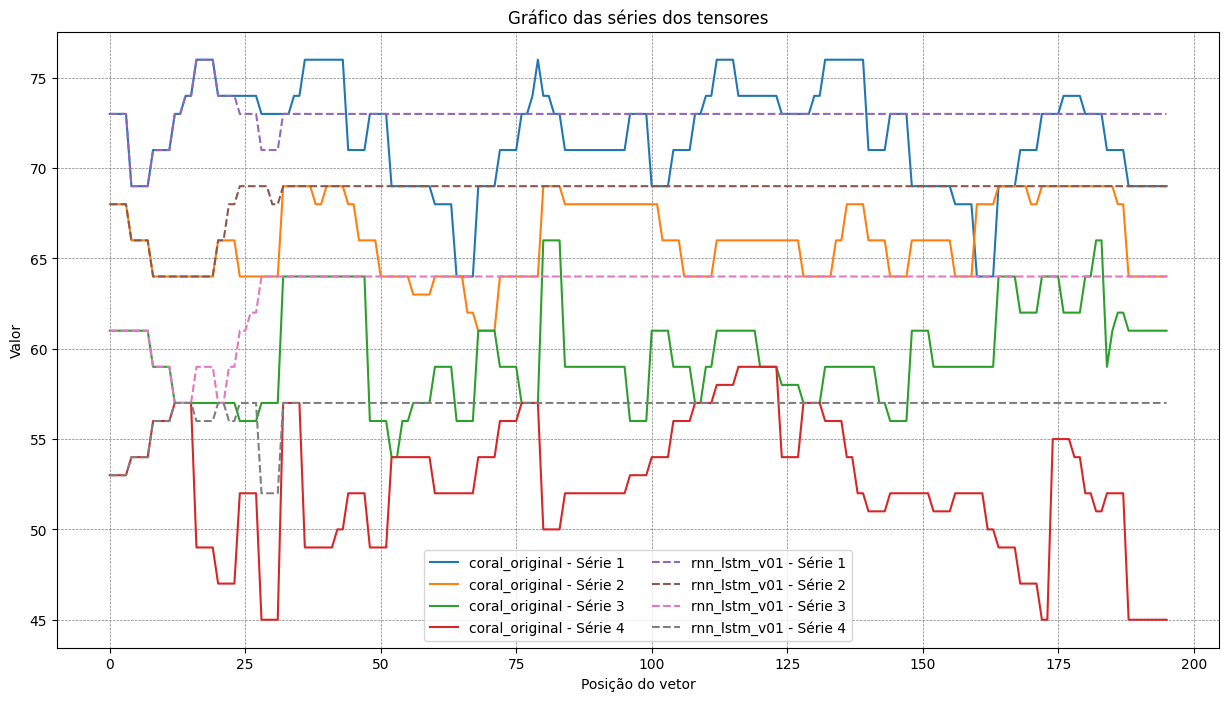

In [ ]:
# Tensores
coral_original = tf.cast(test_chorales[2], tf.int32)
rnn_lstm_v01 = tf.cast(new_chorale_v01, tf.int32)

# Converter para numpy array
data1 = coral_original.numpy()
data2 = rnn_lstm_v01.numpy()

# Ajustar o tamanho da figura
plt.figure(figsize=(15, 8))

# Plotar cada série (coluna) do primeiro tensor
for i in range(data1.shape[1]):
    plt.plot(data1[:, i], linestyle='-', label=f'coral_original - Série {i+1}')

# Plotar cada série (coluna) do segundo tensor com um estilo diferente
for i in range(data2.shape[1]):
    plt.plot(data2[:, i], linestyle='--', label=f'rnn_lstm_v01 - Série {i+1}')

plt.xlabel('Posição do vetor')
plt.ylabel('Valor')
plt.title('Gráfico das séries dos tensores')
plt.legend(ncol=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

## Criando o modelo - RNN - LSTM v.02

In [25]:
n_embedding_dims = 5

model_v02 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(256, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(512, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(1024, return_sequences=True),
    keras.layers.Dense(n_notes, activation="softmax")
])

model_v02.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 5)           235       
                                                                 
 conv1d_4 (Conv1D)           (None, None, 64)          704       
                                                                 
 batch_normalization_4 (Batc  (None, None, 64)         256       
 hNormalization)                                                 
                                                                 
 conv1d_5 (Conv1D)           (None, None, 128)         16512     
                                                                 
 batch_normalization_5 (Batc  (None, None, 128)        512       
 hNormalization)                                                 
                                                                 
 conv1d_6 (Conv1D)           (None, None, 256)        

### Treinando o modelo

In [26]:
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
model_v02.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history_v02 = model_v02.fit(train_set, epochs=20, validation_data=valid_set)

Epoch 1/20
98/98 [==============================] - 18s 105ms/step - loss: 1.0967 - accuracy: 0.7100 - val_loss: 4.4918 - val_accuracy: 0.0432
Epoch 2/20
98/98 [==============================] - 8s 87ms/step - loss: 0.5395 - accuracy: 0.8384 - val_loss: 4.9363 - val_accuracy: 0.0382
Epoch 3/20
98/98 [==============================] - 9s 88ms/step - loss: 0.4058 - accuracy: 0.8747 - val_loss: 3.9334 - val_accuracy: 0.1355
Epoch 4/20
98/98 [==============================] - 9s 89ms/step - loss: 0.3118 - accuracy: 0.9026 - val_loss: 3.3943 - val_accuracy: 0.1909
Epoch 5/20
98/98 [==============================] - 9s 89ms/step - loss: 0.2469 - accuracy: 0.9229 - val_loss: 2.1611 - val_accuracy: 0.3999
Epoch 6/20
98/98 [==============================] - 8s 86ms/step - loss: 0.1975 - accuracy: 0.9382 - val_loss: 0.8815 - val_accuracy: 0.7466
Epoch 7/20
98/98 [==============================] - 9s 87ms/step - loss: 0.1705 - accuracy: 0.9468 - val_loss: 0.6796 - val_accuracy: 0.8165
Epoch 8/20


### Salvando o modelo

In [27]:
model_v02.save("my_bach_model_v02.h5")
model_v02.evaluate(test_set)

34/34 [==============================] - 1s 34ms/step - loss: 0.8478 - accuracy: 0.8199


[0.8478055596351624, 0.8198702335357666]

### Visualizando o treinamento

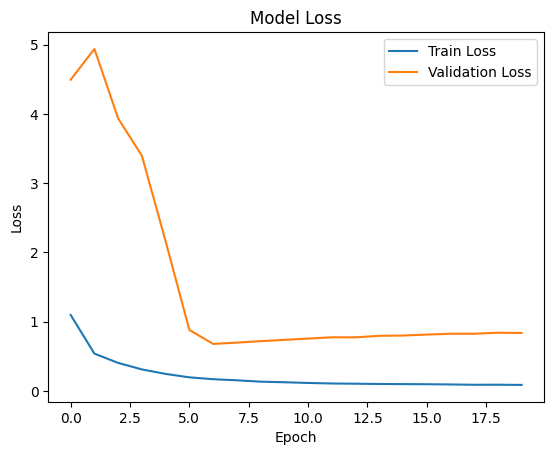

In [28]:
plt.plot(history_v02.history['loss'], label='Train Loss')
plt.plot(history_v02.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Gerando um novo coral

In [29]:
new_chorale_v02 = generate_chorale(model_v02, seed_chords, 180)
play_chords(new_chorale_v02, filepath="new_chorale_v02.wav")

Output hidden; open in https://colab.research.google.com to view.

### Comparações com a criação e a música original




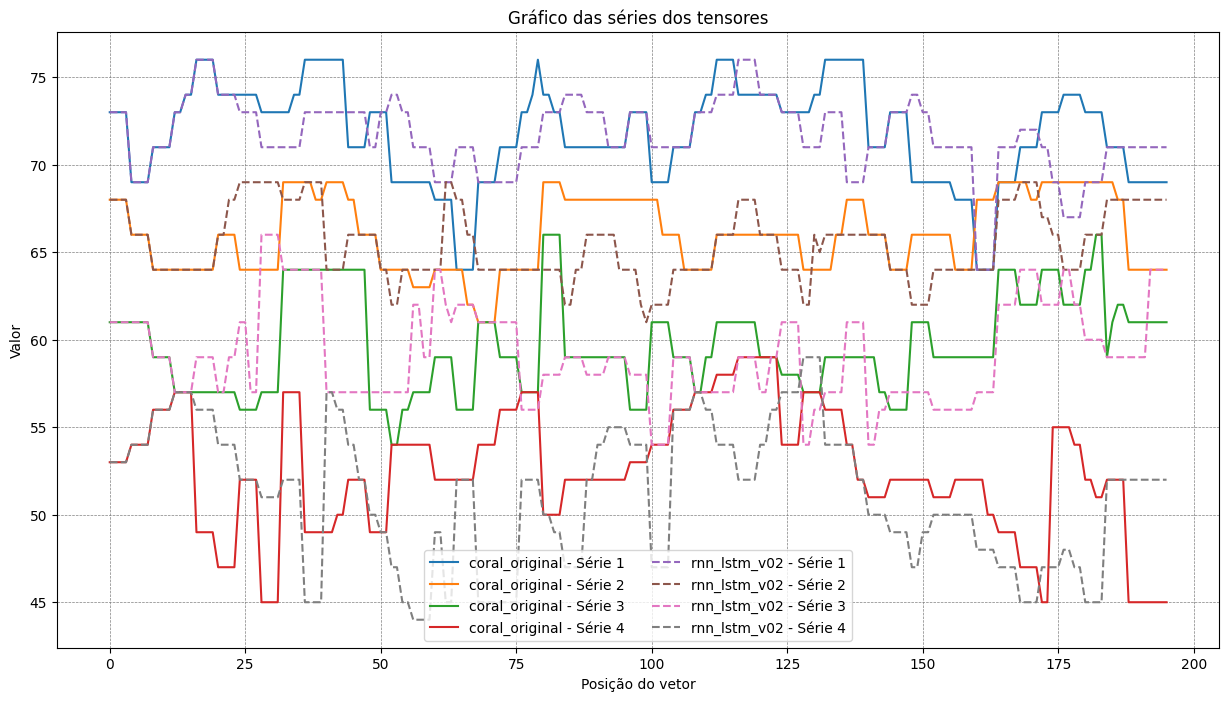

In [30]:
# Tensores
coral_original = tf.cast(test_chorales[2], tf.int32)
rnn_lstm_v02 = tf.cast(new_chorale_v02, tf.int32)

# Converter para numpy array
data1 = coral_original.numpy()
data2 = rnn_lstm_v02.numpy()

# Ajustar o tamanho da figura
plt.figure(figsize=(15, 8))

# Plotar cada série (coluna) do primeiro tensor
for i in range(data1.shape[1]):
    plt.plot(data1[:, i], linestyle='-', label=f'coral_original - Série {i+1}')

# Plotar cada série (coluna) do segundo tensor com um estilo diferente
for i in range(data2.shape[1]):
    plt.plot(data2[:, i], linestyle='--', label=f'rnn_lstm_v02 - Série {i+1}')

plt.xlabel('Posição do vetor')
plt.ylabel('Valor')
plt.title('Gráfico das séries dos tensores')
plt.legend(ncol=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

## Criando o modelo - RNN - LSTM v.03

In [ ]:
import keras

n_embedding_dims = 5

model_v03 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims, input_shape=[None]),

    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),  # Adicionando dropout após a camada Conv1D

    keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),

    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),

    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),

    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.Dropout(0.5),  # Maior dropout após a camada LSTM

    keras.layers.Dense(n_notes, activation="softmax", kernel_regularizer=keras.regularizers.l2(0.01))  # Adicionando regularização L2
])

model_v03.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 5)           235       
                                                                 
 conv1d_8 (Conv1D)           (None, None, 32)          352       
                                                                 
 batch_normalization_8 (Batc  (None, None, 32)         128       
 hNormalization)                                                 
                                                                 
 dropout_11 (Dropout)        (None, None, 32)          0         
                                                                 
 conv1d_9 (Conv1D)           (None, None, 48)          3120      
                                                                 
 batch_normalization_9 (Batc  (None, None, 48)         192       
 hNormalization)                                      

### Treinando o modelo

In [ ]:
# Para a compilação e treinamento:
optimizer = keras.optimizers.Adam()
model_v03.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lr_schedule = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
checkpoint_cb = keras.callbacks.ModelCheckpoint("model_v03.h5", save_best_only=True)


history_v03 = model_v03.fit(train_set, epochs=20, validation_data=valid_set,
                            callbacks=[early_stopping, lr_schedule, checkpoint_cb])

Epoch 1/20
98/98 [==============================] - 5s 23ms/step - loss: 3.0813 - accuracy: 0.2876 - val_loss: 3.2592 - val_accuracy: 0.1457 - lr: 0.0010
Epoch 2/20
98/98 [==============================] - 1s 15ms/step - loss: 1.7636 - accuracy: 0.5855 - val_loss: 2.6849 - val_accuracy: 0.2157 - lr: 0.0010
Epoch 3/20
98/98 [==============================] - 1s 15ms/step - loss: 1.4913 - accuracy: 0.6725 - val_loss: 2.0939 - val_accuracy: 0.4019 - lr: 0.0010
Epoch 4/20
98/98 [==============================] - 1s 15ms/step - loss: 1.3837 - accuracy: 0.7057 - val_loss: 1.6611 - val_accuracy: 0.5920 - lr: 0.0010
Epoch 5/20
98/98 [==============================] - 1s 15ms/step - loss: 1.3268 - accuracy: 0.7203 - val_loss: 1.3347 - val_accuracy: 0.7081 - lr: 0.0010
Epoch 6/20
98/98 [==============================] - 1s 15ms/step - loss: 1.2877 - accuracy: 0.7285 - val_loss: 1.1854 - val_accuracy: 0.7551 - lr: 0.0010
Epoch 7/20
98/98 [==============================] - 1s 15ms/step - loss: 1.2

### Salvando o modelo

In [ ]:
model_v03.save("my_bach_model_v03.h5")
model_v03.evaluate(test_set)

34/34 [==============================] - 0s 6ms/step - loss: 1.0846 - accuracy: 0.7588


[1.084618330001831, 0.7588301301002502]

### Visualizando o treinamento

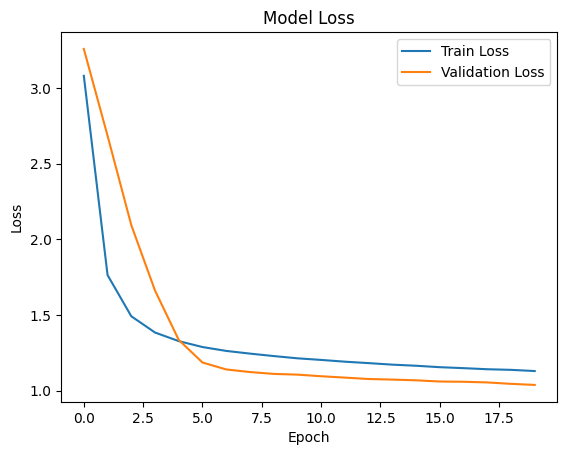

In [ ]:
plt.plot(history_v03.history['loss'], label='Train Loss')
plt.plot(history_v03.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Gerando um novo coral

In [ ]:
new_chorale_v03 = generate_chorale(model_v03, seed_chords, 180)
play_chords(new_chorale_v03, filepath="new_chorale_v03.wav")

Output hidden; open in https://colab.research.google.com to view.

### Comparações com a criação e a música original




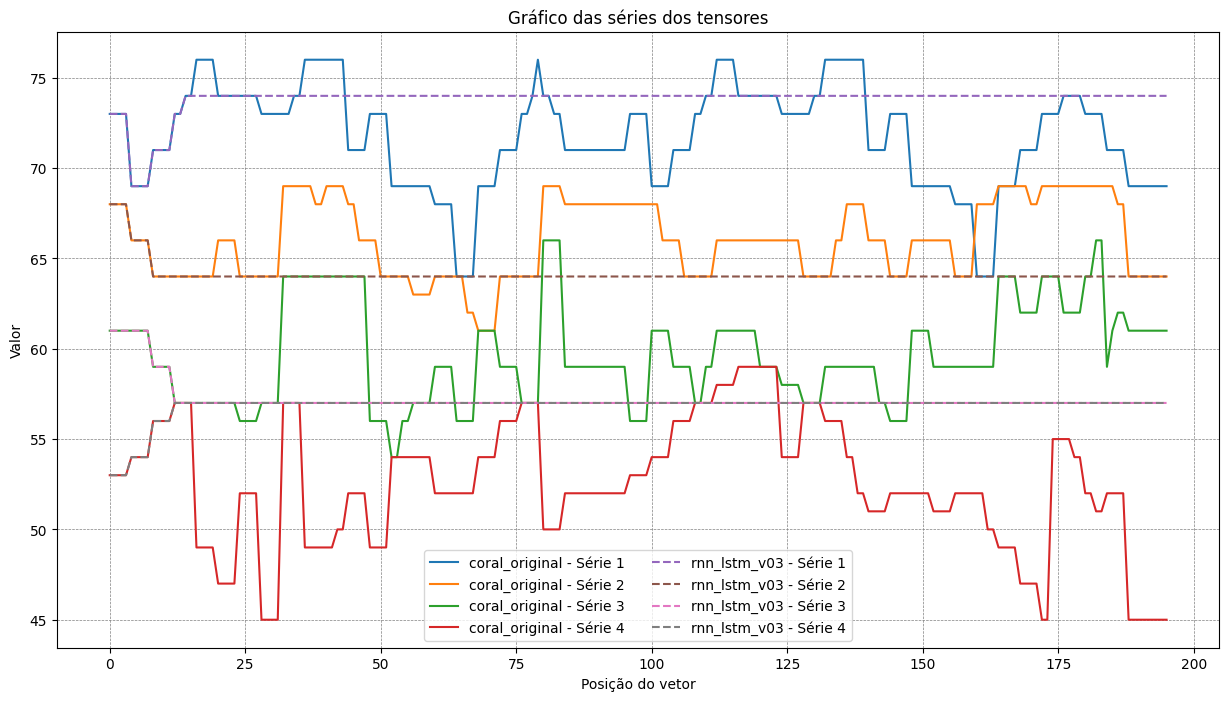

In [ ]:
# Tensores
coral_original = tf.cast(test_chorales[2], tf.int32)
rnn_lstm_v03 = tf.cast(new_chorale_v03, tf.int32)

# Converter para numpy array
data1 = coral_original.numpy()
data2 = rnn_lstm_v03.numpy()

# Ajustar o tamanho da figura
plt.figure(figsize=(15, 8))

# Plotar cada série (coluna) do primeiro tensor
for i in range(data1.shape[1]):
    plt.plot(data1[:, i], linestyle='-', label=f'coral_original - Série {i+1}')

# Plotar cada série (coluna) do segundo tensor com um estilo diferente
for i in range(data2.shape[1]):
    plt.plot(data2[:, i], linestyle='--', label=f'rnn_lstm_v03 - Série {i+1}')

plt.xlabel('Posição do vetor')
plt.ylabel('Valor')
plt.title('Gráfico das séries dos tensores')
plt.legend(ncol=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

## Criando o modelo - RNN - LSTM v.04

In [ ]:
import keras

n_embedding_dims = 5

model_v04 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims, input_shape=[None]),

    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),

    keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),

    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),

    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),

    keras.layers.LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    keras.layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),

    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(n_notes, activation="softmax")
])

model_v04.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 5)           235       
                                                                 
 conv1d_12 (Conv1D)          (None, None, 32)          352       
                                                                 
 batch_normalization_12 (Bat  (None, None, 32)         128       
 chNormalization)                                                
                                                                 
 dropout_16 (Dropout)        (None, None, 32)          0         
                                                                 
 conv1d_13 (Conv1D)          (None, None, 48)          3120      
                                                                 
 batch_normalization_13 (Bat  (None, None, 48)         192       
 chNormalization)                                     

### Treinando o modelo

In [ ]:
optimizer = keras.optimizers.Adam()
model_v04.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lr_schedule = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
checkpoint_cb = keras.callbacks.ModelCheckpoint("model_v04.h5", save_best_only=True)

history_v04 = model_v04.fit(train_set, epochs=20, validation_data=valid_set,
                            callbacks=[early_stopping, lr_schedule, checkpoint_cb])

Epoch 1/20
98/98 [==============================] - 83s 794ms/step - loss: 2.9607 - accuracy: 0.1941 - val_loss: 3.5894 - val_accuracy: 0.1109 - lr: 0.0010
Epoch 2/20
98/98 [==============================] - 77s 786ms/step - loss: 1.4921 - accuracy: 0.6044 - val_loss: 3.6164 - val_accuracy: 0.0891 - lr: 0.0010
Epoch 3/20
98/98 [==============================] - 77s 788ms/step - loss: 1.1087 - accuracy: 0.7161 - val_loss: 2.9302 - val_accuracy: 0.1480 - lr: 0.0010
Epoch 4/20
98/98 [==============================] - 77s 783ms/step - loss: 1.0157 - accuracy: 0.7379 - val_loss: 2.4108 - val_accuracy: 0.2802 - lr: 0.0010
Epoch 5/20
98/98 [==============================] - 77s 785ms/step - loss: 0.9600 - accuracy: 0.7472 - val_loss: 1.2855 - val_accuracy: 0.6348 - lr: 0.0010
Epoch 6/20
98/98 [==============================] - 77s 788ms/step - loss: 0.9138 - accuracy: 0.7548 - val_loss: 0.8907 - val_accuracy: 0.7676 - lr: 0.0010
Epoch 7/20
98/98 [==============================] - 77s 782ms/st

### Salvando o modelo

In [ ]:
model_v04.save("my_bach_model_v04.h5")
model_v04.evaluate(test_set)

34/34 [==============================] - 2s 71ms/step - loss: 0.5999 - accuracy: 0.8175


[0.5999363660812378, 0.8174735307693481]

### Visualizando o treinamento

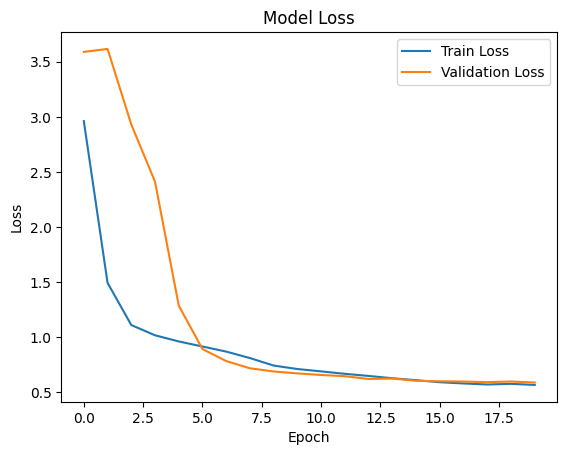

In [ ]:
plt.plot(history_v04.history['loss'], label='Train Loss')
plt.plot(history_v04.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Gerando um novo coral

In [ ]:
new_chorale_v04 = generate_chorale(model_v04, seed_chords, 180)
play_chords(new_chorale_v04, filepath="new_chorale_v04.wav")

Output hidden; open in https://colab.research.google.com to view.

### Comparações com a criação e a música original




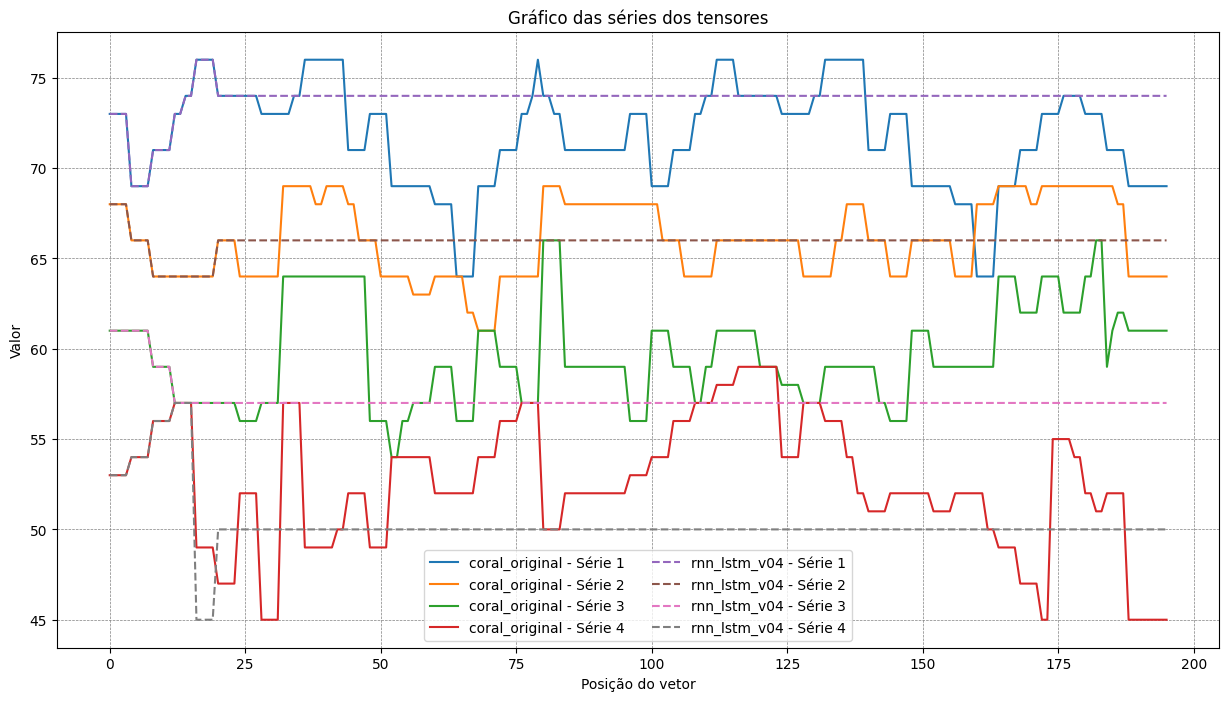

In [ ]:
# Tensores
coral_original = tf.cast(test_chorales[2], tf.int32)
rnn_lstm_v04 = tf.cast(new_chorale_v04, tf.int32)

# Converter para numpy array
data1 = coral_original.numpy()
data2 = rnn_lstm_v04.numpy()

# Ajustar o tamanho da figura
plt.figure(figsize=(15, 8))

# Plotar cada série (coluna) do primeiro tensor
for i in range(data1.shape[1]):
    plt.plot(data1[:, i], linestyle='-', label=f'coral_original - Série {i+1}')

# Plotar cada série (coluna) do segundo tensor com um estilo diferente
for i in range(data2.shape[1]):
    plt.plot(data2[:, i], linestyle='--', label=f'rnn_lstm_v04 - Série {i+1}')

plt.xlabel('Posição do vetor')
plt.ylabel('Valor')
plt.title('Gráfico das séries dos tensores')
plt.legend(ncol=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

## Criando o modelo - RNN - GRU v.01

In [31]:
n_embedding_dims = 5

model_gru_v01 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims, input_shape=[None]),
    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.GRU(256, return_sequences=True),  # Aqui é onde substituímos LSTM por GRU
    keras.layers.Dense(n_notes, activation="softmax")
])

model_gru_v01.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 5)           235       
                                                                 
 conv1d_8 (Conv1D)           (None, None, 32)          352       
                                                                 
 batch_normalization_8 (Batc  (None, None, 32)         128       
 hNormalization)                                                 
                                                                 
 conv1d_9 (Conv1D)           (None, None, 48)          3120      
                                                                 
 batch_normalization_9 (Batc  (None, None, 48)         192       
 hNormalization)                                                 
                                                                 
 conv1d_10 (Conv1D)          (None, None, 64)         

### Treinando o modelo

In [32]:
optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
model_gru_v01.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history_gru_v01 = model_gru_v01.fit(train_set, epochs=20, validation_data=valid_set)

Epoch 1/20
98/98 [==============================] - 11s 38ms/step - loss: 1.7105 - accuracy: 0.5777 - val_loss: 4.2002 - val_accuracy: 0.0700
Epoch 2/20
98/98 [==============================] - 2s 17ms/step - loss: 0.8308 - accuracy: 0.7764 - val_loss: 4.4222 - val_accuracy: 0.0683
Epoch 3/20
98/98 [==============================] - 2s 19ms/step - loss: 0.7106 - accuracy: 0.7991 - val_loss: 3.6751 - val_accuracy: 0.1380
Epoch 4/20
98/98 [==============================] - 2s 17ms/step - loss: 0.6405 - accuracy: 0.8132 - val_loss: 2.5708 - val_accuracy: 0.2926
Epoch 5/20
98/98 [==============================] - 2s 16ms/step - loss: 0.5872 - accuracy: 0.8258 - val_loss: 1.7792 - val_accuracy: 0.4592
Epoch 6/20
98/98 [==============================] - 2s 16ms/step - loss: 0.5417 - accuracy: 0.8361 - val_loss: 0.8576 - val_accuracy: 0.7510
Epoch 7/20
98/98 [==============================] - 2s 18ms/step - loss: 0.5039 - accuracy: 0.8463 - val_loss: 0.6619 - val_accuracy: 0.8083
Epoch 8/20
9

### Salvando o modelo

In [33]:
model_gru_v01.save("my_bach_model_gru_v01.h5")
model_gru_v01.evaluate(test_set)

34/34 [==============================] - 0s 10ms/step - loss: 0.7046 - accuracy: 0.8145


[0.7045754790306091, 0.8144687414169312]

### Visualizando o treinamento

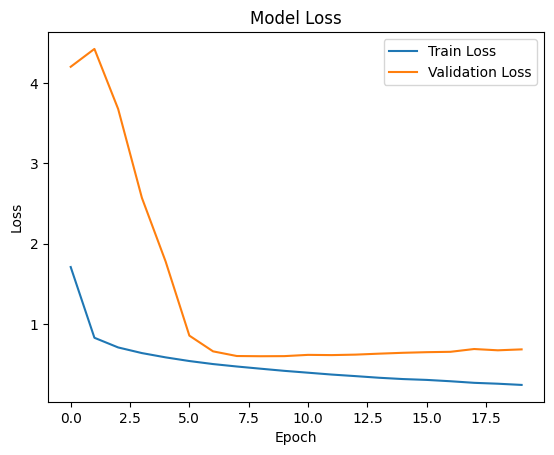

In [34]:
plt.plot(history_gru_v01.history['loss'], label='Train Loss')
plt.plot(history_gru_v01.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Gerando um novo coral

In [35]:
new_chorale_gru_v01 = generate_chorale(model_gru_v01, seed_chords, 180)
play_chords(new_chorale_gru_v01, filepath="new_chorale_gru_v01.wav")

Output hidden; open in https://colab.research.google.com to view.

### Comparações com a criação e a música original




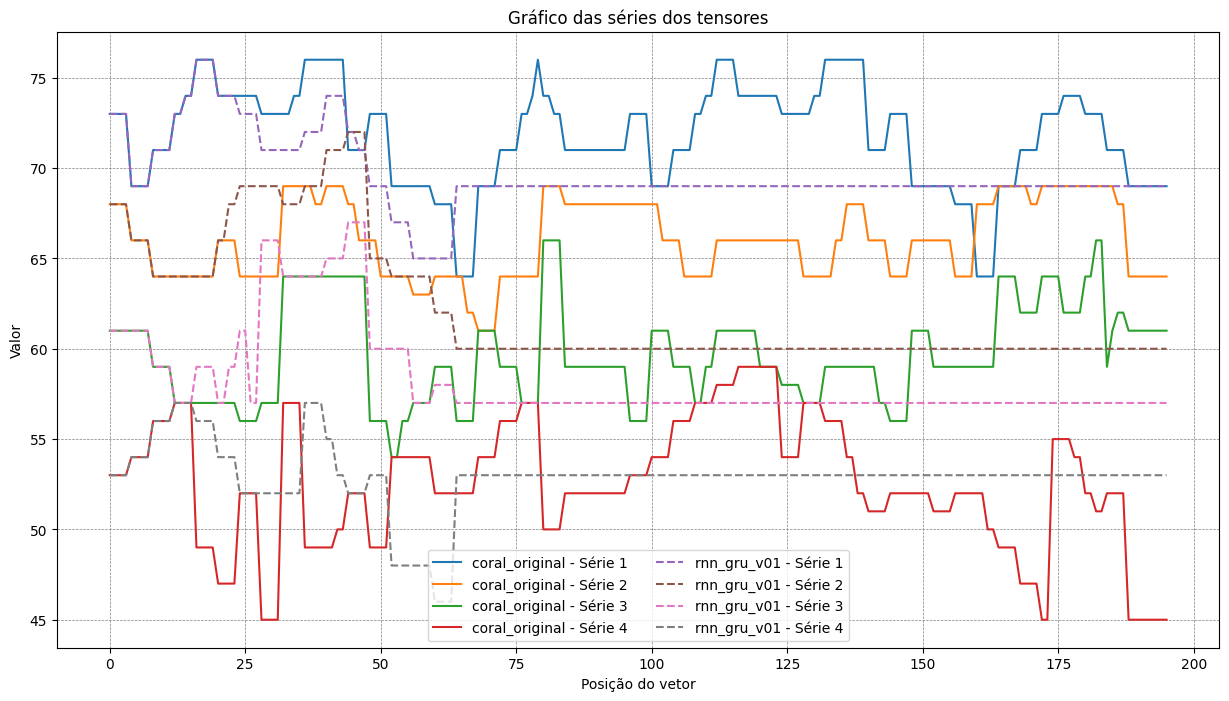

In [36]:
# Tensores
coral_original = tf.cast(test_chorales[2], tf.int32)
rnn_gru_v01 = tf.cast(new_chorale_gru_v01, tf.int32)

# Converter para numpy array
data1 = coral_original.numpy()
data2 = rnn_gru_v01.numpy()

# Ajustar o tamanho da figura
plt.figure(figsize=(15, 8))

# Plotar cada série (coluna) do primeiro tensor
for i in range(data1.shape[1]):
    plt.plot(data1[:, i], linestyle='-', label=f'coral_original - Série {i+1}')

# Plotar cada série (coluna) do segundo tensor com um estilo diferente
for i in range(data2.shape[1]):
    plt.plot(data2[:, i], linestyle='--', label=f'rnn_gru_v01 - Série {i+1}')

plt.xlabel('Posição do vetor')
plt.ylabel('Valor')
plt.title('Gráfico das séries dos tensores')
plt.legend(ncol=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

## Criando o modelo - Transformer v.01

In [37]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # aplicar função seno aos índices pares na matriz; 2i
        sines = tf.math.sin(angle_rads[:, 0::2])
        # aplicar função cosseno aos índices ímpares na matriz; 2i+1
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# Uso
n_embedding_dims = 5
position = 500  # ou qualquer valor suficientemente grande para sua sequência
pos_enc = PositionalEncoding(position, n_embedding_dims)


### Treinando o modelo

In [38]:
import keras
from keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dense, Dropout

n_embedding_dims = 64  # Aumentando as dimensões de incorporação para o Transformer

inputs = Input(shape=[None])

# Embedding layers
x = Embedding(input_dim=n_notes, output_dim=n_embedding_dims)(inputs)
pos_enc = PositionalEncoding(position, n_embedding_dims)

x = pos_enc(x)

# Transformer block
x = LayerNormalization()(x)
attention_output = MultiHeadAttention(num_heads=8, key_dim=n_embedding_dims)(x, x)
x = keras.layers.Add()([x, attention_output])
x = Dropout(0.2)(x)

x = LayerNormalization()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.2)(x)

outputs = Dense(n_notes, activation="softmax")(x)

model_t_v01 = keras.Model(inputs=inputs, outputs=outputs)

optimizer = keras.optimizers.Adam()
model_t_v01.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lr_schedule = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
checkpoint_cb = keras.callbacks.ModelCheckpoint("model_v04.h5", save_best_only=True)

history_t_v01 = model_t_v01.fit(train_set, epochs=20, validation_data=valid_set,
                         callbacks=[early_stopping, lr_schedule, checkpoint_cb])

Epoch 1/20
98/98 [==============================] - 3s 19ms/step - loss: 3.2956 - accuracy: 0.0967 - val_loss: 2.7068 - val_accuracy: 0.1804 - lr: 0.0010
Epoch 2/20
98/98 [==============================] - 1s 15ms/step - loss: 2.5653 - accuracy: 0.1942 - val_loss: 2.3446 - val_accuracy: 0.2536 - lr: 0.0010
Epoch 3/20
98/98 [==============================] - 1s 15ms/step - loss: 2.1620 - accuracy: 0.2962 - val_loss: 1.8274 - val_accuracy: 0.4039 - lr: 0.0010
Epoch 4/20
98/98 [==============================] - 1s 15ms/step - loss: 1.6934 - accuracy: 0.4545 - val_loss: 1.3120 - val_accuracy: 0.6018 - lr: 0.0010
Epoch 5/20
98/98 [==============================] - 1s 15ms/step - loss: 1.0614 - accuracy: 0.6834 - val_loss: 0.6526 - val_accuracy: 0.8225 - lr: 0.0010
Epoch 6/20
98/98 [==============================] - 1s 15ms/step - loss: 0.4538 - accuracy: 0.8762 - val_loss: 0.1927 - val_accuracy: 0.9527 - lr: 0.0010
Epoch 7/20
98/98 [==============================] - 1s 15ms/step - loss: 0.1

### Salvando o modelo

In [39]:
model_t_v01.save("my_bach_model_t_v01.h5")
model_t_v01.evaluate(test_set)

34/34 [==============================] - 0s 7ms/step - loss: 0.0159 - accuracy: 0.9952


[0.015898821875452995, 0.9951708912849426]

### Visualizando o treinameto

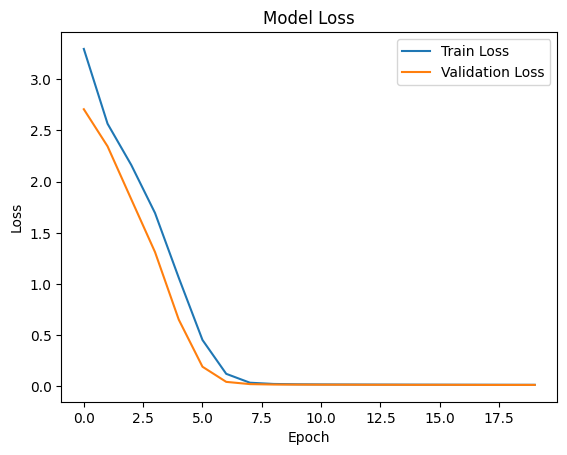

In [40]:
plt.plot(history_t_v01.history['loss'], label='Train Loss')
plt.plot(history_t_v01.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Gerando um outro coral

In [43]:
new_chorale_t_v01 = generate_chorale(model_t_v01, seed_chords, 100)
play_chords(new_chorale_t_v01, filepath="new_chorale_t_v01.wav")

Output hidden; open in https://colab.research.google.com to view.

### Comparações com a criação e a música original




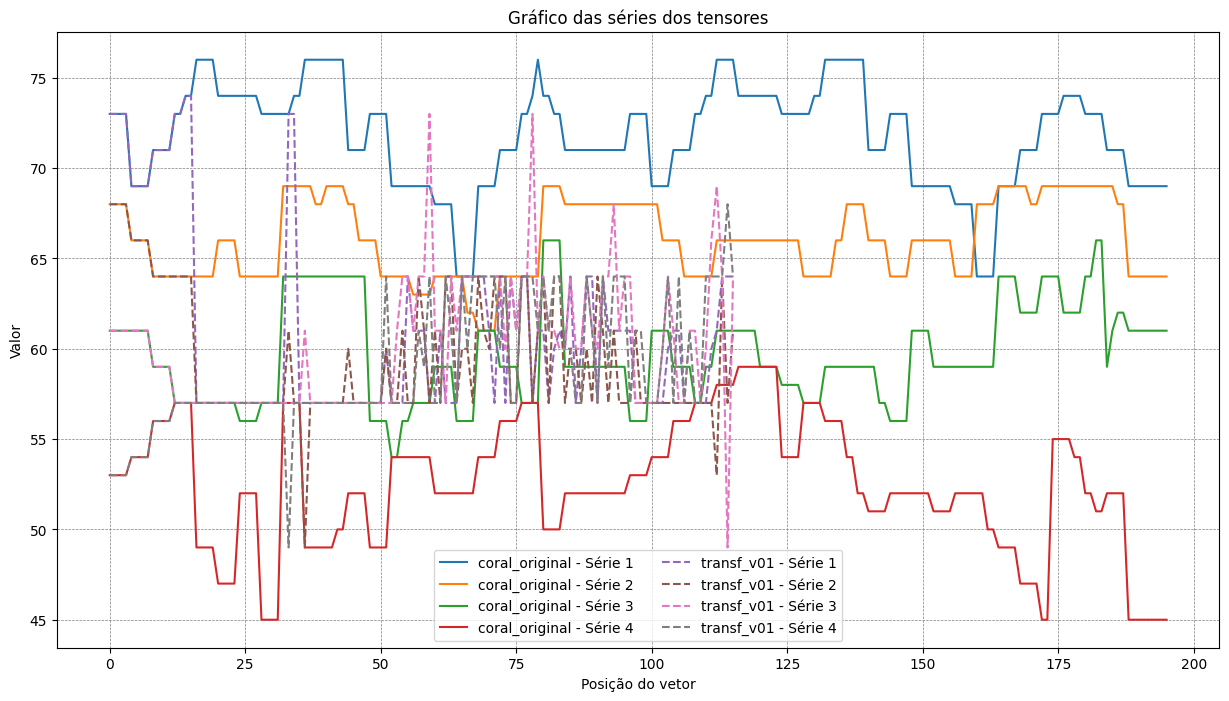

In [44]:
# Tensores
coral_original = tf.cast(test_chorales[2], tf.int32)
transf_v01 = tf.cast(new_chorale_t_v01, tf.int32)

# Converter para numpy array
data1 = coral_original.numpy()
data2 = transf_v01.numpy()

# Ajustar o tamanho da figura
plt.figure(figsize=(15, 8))

# Plotar cada série (coluna) do primeiro tensor
for i in range(data1.shape[1]):
    plt.plot(data1[:, i], linestyle='-', label=f'coral_original - Série {i+1}')

# Plotar cada série (coluna) do segundo tensor com um estilo diferente
for i in range(data2.shape[1]):
    plt.plot(data2[:, i], linestyle='--', label=f'transf_v01 - Série {i+1}')

plt.xlabel('Posição do vetor')
plt.ylabel('Valor')
plt.title('Gráfico das séries dos tensores')
plt.legend(ncol=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

## Criando um modelo - GAN

In [45]:
# Gerador
def build_generator(latent_dim=100, output_dim=32):
    model = keras.models.Sequential([
        keras.layers.Dense(128, activation='relu', input_dim=latent_dim),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(output_dim, activation='tanh')
    ])
    return model

# Discriminador
def build_discriminator(input_dim=32):
    model = keras.models.Sequential([
        keras.layers.Dense(512, activation='relu', input_dim=input_dim),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [46]:
def build_gan(generator, discriminator, latent_dim=100):
    discriminator.trainable = False
    gan_input = keras.layers.Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = keras.models.Model(gan_input, gan_output)
    return gan

generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

In [47]:
discriminator.compile(optimizer=keras.optimizers.Adam(0.0002, 0.5),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

gan.compile(optimizer=keras.optimizers.Adam(0.0002, 0.5), loss='binary_crossentropy')

###Treinando o modelo

In [48]:
def train_gan(gan, generator, discriminator, dataset, epochs, batch_size=128, latent_dim=100):
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # 1. Criar listas para armazenar as perdas
    d_losses_real = []
    d_losses_fake = []
    g_losses = []

    for epoch in range(epochs):
        # Treinando o discriminador
        real_data_list = [instance[0].numpy() for instance in next(iter(dataset.take(batch_size)))]

        # Se a quantidade de real_data não for igual ao batch_size, pule esta época
        if len(real_data_list) != batch_size:
            continue

        real_data = np.array(real_data_list)
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        generated_data = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_data, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Treinando o gerador
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, real_labels)

        # 2. Adicionar perdas às listas
        d_losses_real.append(d_loss_real[0])
        d_losses_fake.append(d_loss_fake[0])
        g_losses.append(g_loss)

        print(f"Epoch: {epoch + 1}, D Loss Real: {d_loss_real[0]}, D Loss Fake: {d_loss_fake[0]}, G Loss: {g_loss}")

    return generator, d_losses_real, d_losses_fake, g_losses

### Salvando o modelo

In [49]:
generator_trained, d_losses_real, d_losses_fake, g_losses = train_gan(gan, generator, discriminator, train_set, epochs=100, batch_size=128)

###Visualizando o treinamento

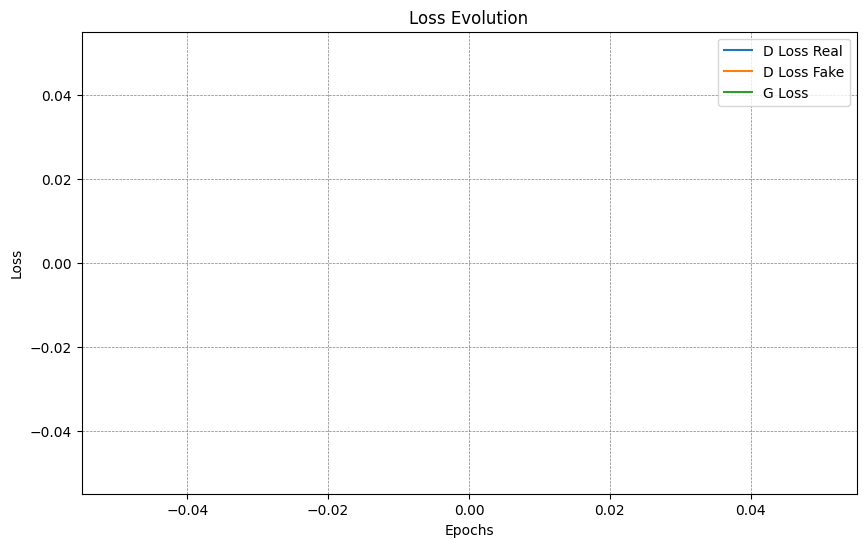

In [50]:
    plt.figure(figsize=(10, 6))
    plt.plot(d_losses_real, label="D Loss Real")
    plt.plot(d_losses_fake, label="D Loss Fake")
    plt.plot(g_losses, label="G Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Evolution")
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
    plt.show()

###Gerando um outro coral

In [51]:
def generate_chorale_gan(generator, seed_chords, length, latent_dim=100):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])

    for chord in range(length):
        noise = np.random.normal(0, 1, (1, latent_dim))
        generated_notes = generator.predict(noise)
        # Adapte a próxima linha conforme necessário para formatar a saída gerada
        generated_notes = np.round(generated_notes * 127).astype(int)  # converta para intervalo MIDI se a saída estiver entre 0 e 1
        arpegio = tf.concat([arpegio, tf.constant(generated_notes, dtype=tf.int64)], axis=1)

    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])


In [52]:
generated_chords = generate_chorale_gan(generator_trained, seed_chords, length=20)

1/1 [==============================] - 0s 17ms/step


In [53]:
play_chords(generated_chords, filepath="generated_chords_gan.wav")

Output hidden; open in https://colab.research.google.com to view.

### Comparações entre a criação e a música original

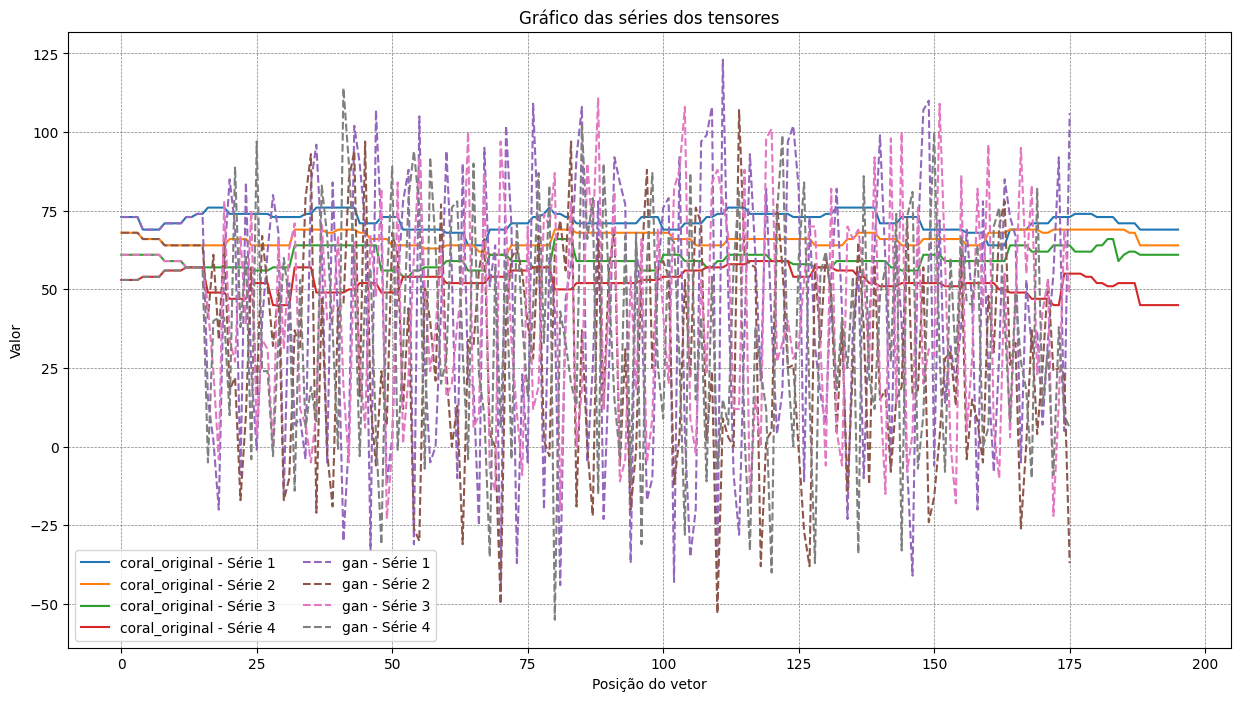

In [54]:
# Tensores
coral_original = tf.cast(test_chorales[2], tf.int32)
gan = tf.cast(generated_chords, tf.int32)

# Converter para numpy array
data1 = coral_original.numpy()
data2 = gan.numpy()

# Ajustar o tamanho da figura
plt.figure(figsize=(15, 8))

# Plotar cada série (coluna) do primeiro tensor
for i in range(data1.shape[1]):
    plt.plot(data1[:, i], linestyle='-', label=f'coral_original - Série {i+1}')

# Plotar cada série (coluna) do segundo tensor com um estilo diferente
for i in range(data2.shape[1]):
    plt.plot(data2[:, i], linestyle='--', label=f'gan - Série {i+1}')

plt.xlabel('Posição do vetor')
plt.ylabel('Valor')
plt.title('Gráfico das séries dos tensores')
plt.legend(ncol=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

## Criando o modelo - Transformer v.02

In [ ]:
# Por exemplo, se train_set e valid_set são instâncias de tf.data.Dataset, você pode ajustar as formas assim:
#train_set = train_set.map(lambda x, y: (x, tf.reshape(y, [-1, 131])))
#valid_set = valid_set.map(lambda x, y: (x, tf.reshape(y, [-1, 131])))

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dense, Dropout, Add, Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import Model

n_embedding_dims = 64
n_transformer_blocks = 4  # Número de blocos Transformer
n_heads = 8  # Número de "heads" na atenção multi-cabeça

def transformer_block(embedding_dims, n_heads):
    """ Um bloco Transformer. """
    input_layer = Input(shape=(None, embedding_dims))

    # Mecanismo de Atenção Multi-Cabeça
    attention = MultiHeadAttention(num_heads=n_heads, key_dim=embedding_dims)(input_layer, input_layer)
    attention = Dropout(0.1)(attention)
    attention = Add()([input_layer, attention])
    attention = LayerNormalization()(attention)

    # Feed-forward network
    ff = Dense(512, activation='relu')(attention)
    ff = Dense(embedding_dims)(ff)
    ff = Dropout(0.1)(ff)
    ff = Add()([attention, ff])
    ff = LayerNormalization()(ff)

    return Model(inputs=input_layer, outputs=ff)

# Implementando codificação posicional
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # apply sin to even indices in the array; 2i
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd indices in the array; 2i+1
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# Assuming n_notes and position are already defined
#n_notes = ...
#position = ...

# Camada de entrada
inputs = Input(shape=[None])

# Embedding layers
x = Embedding(input_dim=n_notes, output_dim=n_embedding_dims)(inputs)
pos_enc = PositionalEncoding(position, n_embedding_dims)
x = pos_enc(x)

# Blocos Transformer
for _ in range(n_transformer_blocks):
    x = transformer_block(n_embedding_dims, n_heads)(x)

# Camada de saída
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dense(n_notes, activation="softmax")(x)

model_t_v02 = Model(inputs=inputs, outputs=x)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_t_v02.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_t_v02.h5", save_best_only=True)

history_t_v02 = model_t_v02.fit(train_set, epochs=20, validation_data=valid_set,
                         callbacks=[early_stopping, lr_schedule, checkpoint_cb])


Epoch 1/20


InvalidArgumentError: ignored

In [ ]:
import keras
from keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dense, Dropout, Add, Flatten
from keras.layers import TimeDistributed

n_embedding_dims = 64
n_transformer_blocks = 4  # Número de blocos Transformer
n_heads = 8  # Número de "heads" na atenção multi-cabeça

def transformer_block(embedding_dims, n_heads):
    """ Um bloco Transformer. """
    input_layer = Input(shape=(None, embedding_dims))

    # Mecanismo de Atenção Multi-Cabeça
    attention = MultiHeadAttention(num_heads=n_heads, key_dim=embedding_dims)(input_layer, input_layer)
    attention = Dropout(0.1)(attention)
    attention = Add()([input_layer, attention])
    attention = LayerNormalization()(attention)

    # Feed-forward network
    ff = Dense(512, activation='relu')(attention)
    ff = Dense(embedding_dims)(ff)
    ff = Dropout(0.1)(ff)
    ff = Add()([attention, ff])
    ff = LayerNormalization()(ff)

    return keras.Model(inputs=input_layer, outputs=ff)

# Camada de entrada
inputs = Input(shape=[None])

# Embedding layers
x = Embedding(input_dim=n_notes, output_dim=n_embedding_dims)(inputs)
pos_enc = PositionalEncoding(position, n_embedding_dims)
x = pos_enc(x)

# Blocos Transformer
for _ in range(n_transformer_blocks):
    x = transformer_block(n_embedding_dims, n_heads)(x)

# Camada de saída
x = keras.layers.GlobalAveragePooling1D()(x)
x = Dense(n_notes, activation="softmax")(x)

model_t_v02 = keras.Model(inputs=inputs, outputs=x)

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_t_v02.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lr_schedule = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
checkpoint_cb = keras.callbacks.ModelCheckpoint("model_t_v02.h5", save_best_only=True)


history_t_v02 = model_t_v02.fit(train_set, epochs=20, validation_data=valid_set,
                         callbacks=[early_stopping, lr_schedule, checkpoint_cb])

# Substitua pelos seus dados
# history = model_v05.fit(train_data, train_labels, epochs=100, validation_data=(val_data, val_labels),
#                         callbacks=[early_stopping, lr_schedule, checkpoint_cb])


# Adicionando o parâmetro `temperature` na geração de novos corais

In [55]:
def generate_chorale_v2(model, seed_chords, length, temperature=1, verbose=False):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))  # Pré-processa os acordes iniciais para obter o arpejo
    arpegio = tf.reshape(arpegio, [1, -1])  # Redimensiona o arpejo para ter formato [1, comprimento]
    for chord in range(length):  # Loop para gerar acordes adicionais
        for note in range(4):  # Loop para gerar cada nota do acorde
            next_note_probas = model.predict(arpegio, verbose=0)[0, -1:]  # Probabilidades previstas para a próxima nota
            rescaled_logits = tf.math.log(next_note_probas) / temperature  # Ajusta as probabilidades de acordo com a temperatura
            next_note = tf.random.categorical(rescaled_logits, num_samples=1)  # Escolhe a próxima nota aleatoriamente de acordo com as probabilidades ajustadas
            arpegio = tf.concat([arpegio, next_note], axis=1)  # Concatena a próxima nota ao arpejo
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)  # Ajusta os valores do arpejo
    return tf.reshape(arpegio, shape=[-1, 4])  # Redimensiona o arpejo para ter formato de acordes


Neste código, a função `generate_chorale_v2` é uma versão modificada da função anterior que gera um coral com base em acordes iniciais usando o modelo treinado. As modificações introduzem a aleatoriedade nas escolhas das notas de acordo com as probabilidades previstas e a temperatura especificada.

* Os acordes iniciais são pré-processados e convertidos em arpejo usando a função `preprocess`.

* Em seguida, o arpejo é redimensionado para ter formato [1, comprimento].

* O código entra em um loop externo para gerar acordes adicionais.

* Dentro desse loop externo, há um loop interno que itera sobre cada nota do acorde.

* As probabilidades previstas para a próxima nota são obtidas usando `model.predict(arpegio)[0, -1:]`. Essas probabilidades são um vetor que representa a distribuição de probabilidade para cada possível nota.

* Os logitos (log-odds) são recalibrados usando a temperatura especificada. Isso é feito aplicando o logaritmo às probabilidades e dividindo pelo valor da temperatura. A temperatura controla a "ousadia" do sistema, pois afeta a dispersão das probabilidades.

* A próxima nota é escolhida aleatoriamente com base nas probabilidades recalibradas usando `tf.random.categorical`. O número de amostras é definido como 1, para escolher apenas uma nota.

* A próxima nota é concatenada ao arpejo usando `tf.concat`, expandindo o comprimento do arpejo.

* Após gerar todas as notas do acorde, o código ajusta os valores do arpejo usando `tf.where`, adicionando `min_note - 1` aos valores não nulos, para retornar as notas originais do coral.

* Por fim, o arpejo é redimensionado novamente para ter o formato de acordes [número_de_acordes, 4], onde cada acorde contém 4 notas.

Essa função gera um coral com base nos acordes iniciais fornecidos, usando o modelo treinado com a introdução da aleatoriedade nas escolhas das notas de acordo com as probabilidades previstas e a temperatura especificada.

# Criando chorais com diferentes nuaces sonoras

Vamos gerar 3 corais usando essa nova função: um frio, um médio e um quente.

Mude as sementes, comprimentos, temperaturas e veja os resultsos.

O código salva cada coral em um arquivo separado. Você pode executar essas células quantas vezes quiser!

## Coral original

In [56]:
play_chords(test_chorales[2][:64], filepath="bach_test_4.wav")

Output hidden; open in https://colab.research.google.com to view.

### Nível conservador

In [57]:
temp_conservador = 0.5

#### RNN v.01

In [58]:
new_chorale_v2_cold_v01 = generate_chorale_v2(model_v01, seed_chords, 180, temperature=temp_conservador, verbose=True)
play_chords(new_chorale_v2_cold_v01, filepath="bach_cold_v01.wav")

Output hidden; open in https://colab.research.google.com to view.

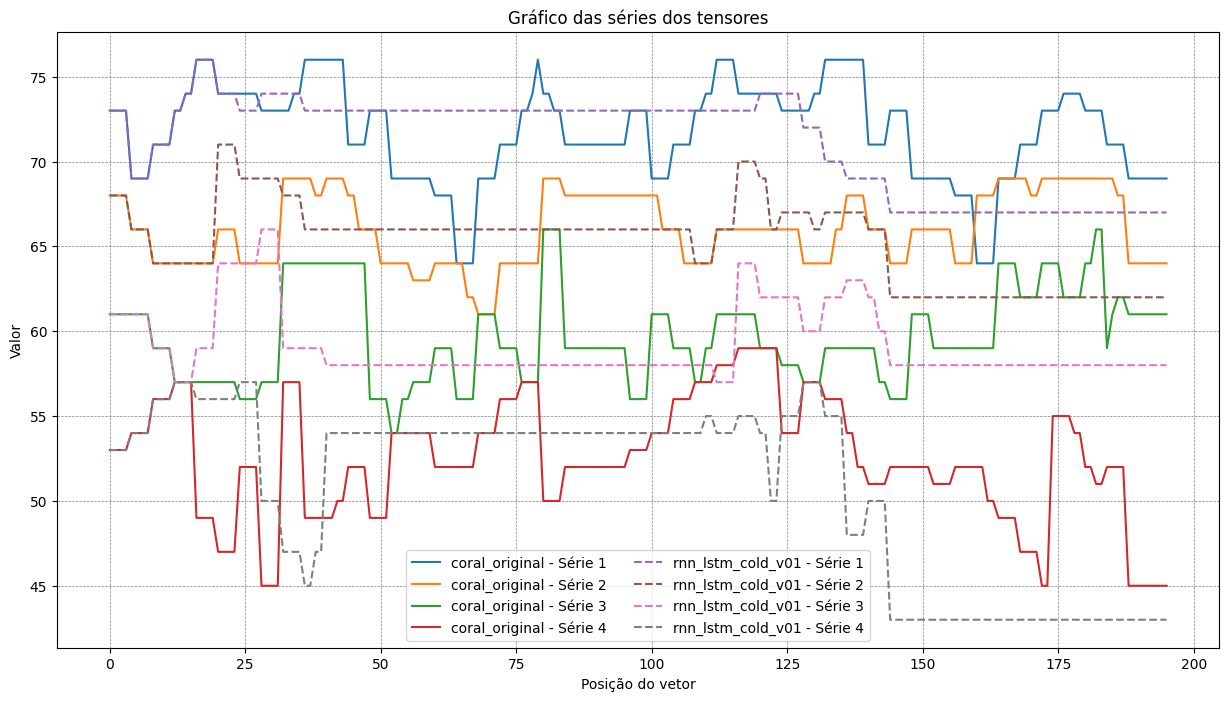

In [59]:
# Tensores
coral_original = tf.cast(test_chorales[2], tf.int32)
rnn_lstm_cold_v01 = tf.cast(new_chorale_v2_cold_v01, tf.int32)

# Converter para numpy array
data1 = coral_original.numpy()
data2 = rnn_lstm_cold_v01.numpy()

# Ajustar o tamanho da figura
plt.figure(figsize=(15, 8))

# Plotar cada série (coluna) do primeiro tensor
for i in range(data1.shape[1]):
    plt.plot(data1[:, i], linestyle='-', label=f'coral_original - Série {i+1}')

# Plotar cada série (coluna) do segundo tensor com um estilo diferente
for i in range(data2.shape[1]):
    plt.plot(data2[:, i], linestyle='--', label=f'rnn_lstm_cold_v01 - Série {i+1}')

plt.xlabel('Posição do vetor')
plt.ylabel('Valor')
plt.title('Gráfico das séries dos tensores')
plt.legend(ncol=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

#### RNN v.02

In [60]:
new_chorale_v2_cold_v02 = generate_chorale_v2(model_v02, seed_chords, 180, temperature=temp_conservador)
play_chords(new_chorale_v2_cold_v02, filepath="bach_cold_v02.wav")

Output hidden; open in https://colab.research.google.com to view.

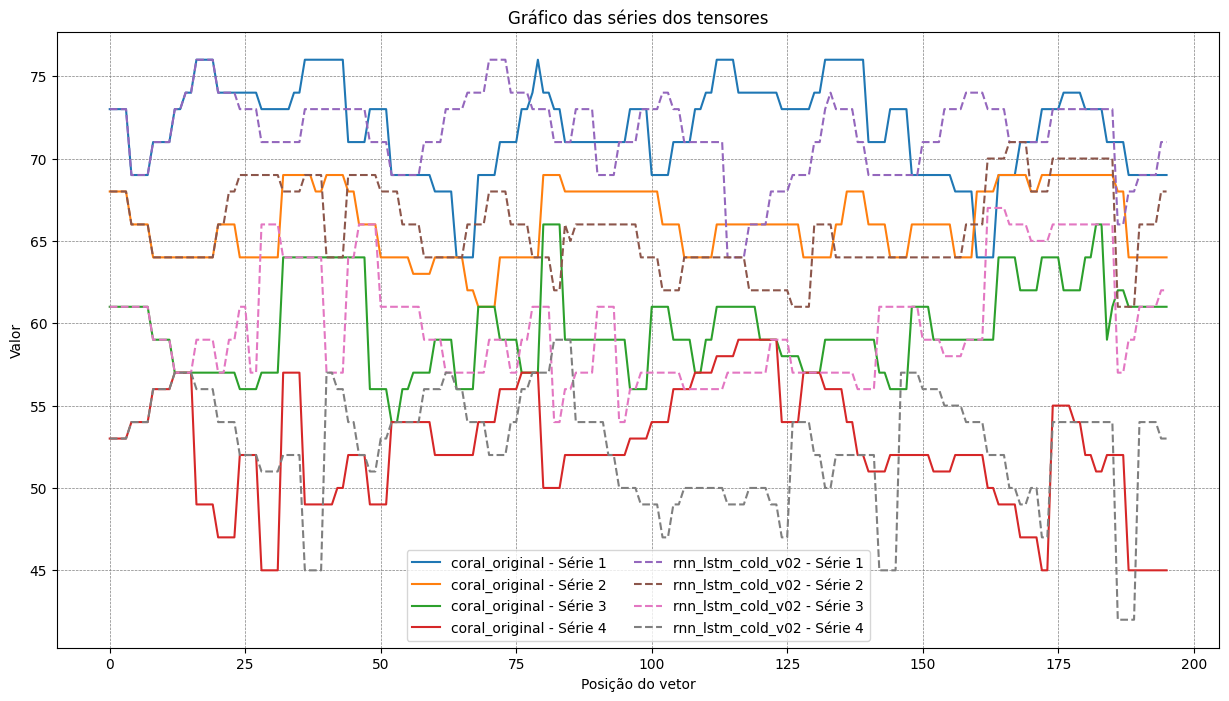

In [61]:
# Tensores
coral_original = tf.cast(test_chorales[2], tf.int32)
rnn_lstm_cold_v02 = tf.cast(new_chorale_v2_cold_v02, tf.int32)

# Converter para numpy array
data1 = coral_original.numpy()
data2 = rnn_lstm_cold_v02.numpy()

# Ajustar o tamanho da figura
plt.figure(figsize=(15, 8))

# Plotar cada série (coluna) do primeiro tensor
for i in range(data1.shape[1]):
    plt.plot(data1[:, i], linestyle='-', label=f'coral_original - Série {i+1}')

# Plotar cada série (coluna) do segundo tensor com um estilo diferente
for i in range(data2.shape[1]):
    plt.plot(data2[:, i], linestyle='--', label=f'rnn_lstm_cold_v02 - Série {i+1}')

plt.xlabel('Posição do vetor')
plt.ylabel('Valor')
plt.title('Gráfico das séries dos tensores')
plt.legend(ncol=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

#### RNN v.03

In [ ]:
new_chorale_v2_cold_v03 = generate_chorale_v2(model_v03, seed_chords, 180, temperature=temp_conservador)
play_chords(new_chorale_v2_cold_v03, filepath="bach_cold_v03.wav")

Output hidden; open in https://colab.research.google.com to view.

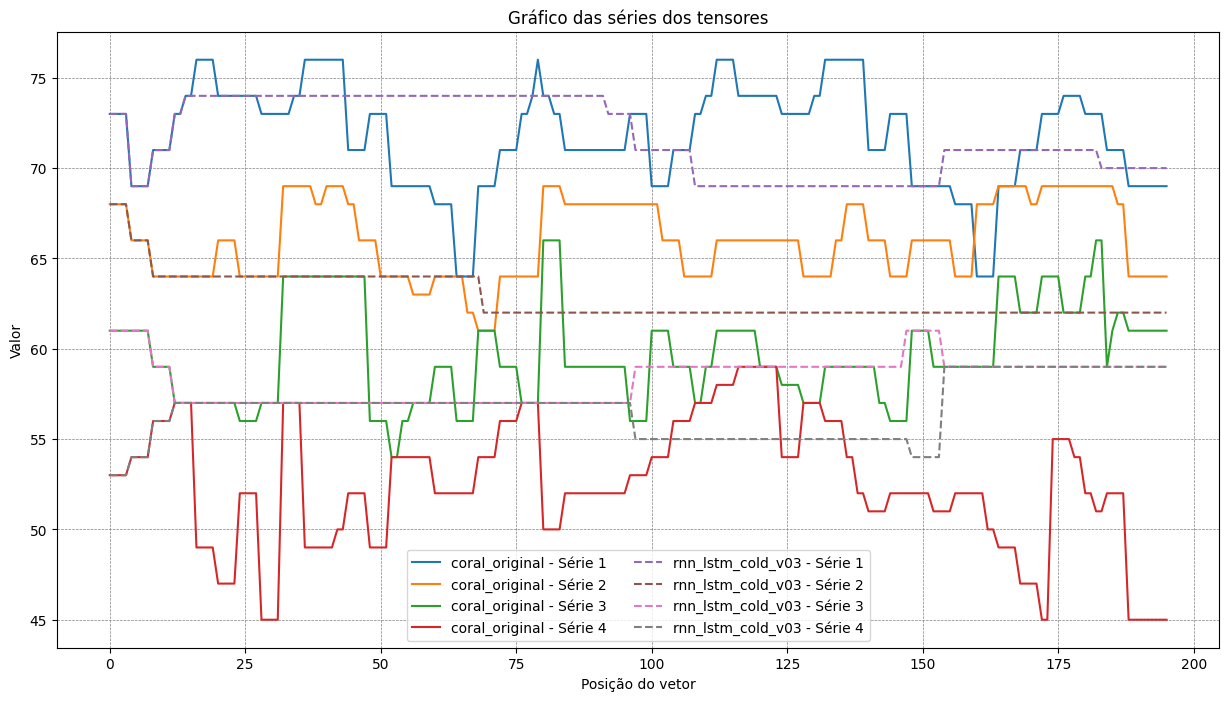

In [ ]:
# Tensores
coral_original = tf.cast(test_chorales[2], tf.int32)
rnn_lstm_cold_v03 = tf.cast(new_chorale_v2_cold_v03, tf.int32)

# Converter para numpy array
data1 = coral_original.numpy()
data2 = rnn_lstm_cold_v03.numpy()

# Ajustar o tamanho da figura
plt.figure(figsize=(15, 8))

# Plotar cada série (coluna) do primeiro tensor
for i in range(data1.shape[1]):
    plt.plot(data1[:, i], linestyle='-', label=f'coral_original - Série {i+1}')

# Plotar cada série (coluna) do segundo tensor com um estilo diferente
for i in range(data2.shape[1]):
    plt.plot(data2[:, i], linestyle='--', label=f'rnn_lstm_cold_v03 - Série {i+1}')

plt.xlabel('Posição do vetor')
plt.ylabel('Valor')
plt.title('Gráfico das séries dos tensores')
plt.legend(ncol=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

#### RNN v.04

In [ ]:
new_chorale_v2_cold_v04 = generate_chorale_v2(model_v04, seed_chords, 180, temperature=temp_conservador)
play_chords(new_chorale_v2_cold_v04, filepath="bach_cold_v04.wav")

Output hidden; open in https://colab.research.google.com to view.

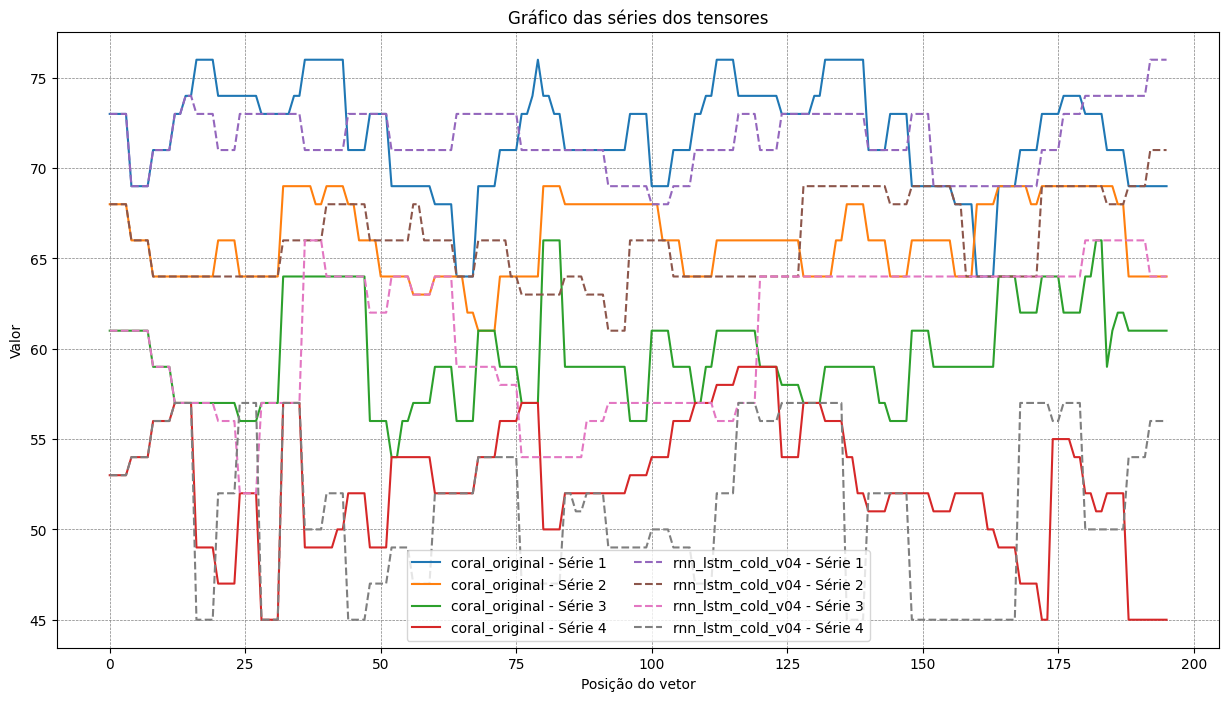

In [ ]:
# Tensores
coral_original = tf.cast(test_chorales[2], tf.int32)
rnn_lstm_cold_v04 = tf.cast(new_chorale_v2_cold_v04, tf.int32)

# Converter para numpy array
data1 = coral_original.numpy()
data2 = rnn_lstm_cold_v04.numpy()

# Ajustar o tamanho da figura
plt.figure(figsize=(15, 8))

# Plotar cada série (coluna) do primeiro tensor
for i in range(data1.shape[1]):
    plt.plot(data1[:, i], linestyle='-', label=f'coral_original - Série {i+1}')

# Plotar cada série (coluna) do segundo tensor com um estilo diferente
for i in range(data2.shape[1]):
    plt.plot(data2[:, i], linestyle='--', label=f'rnn_lstm_cold_v04 - Série {i+1}')

plt.xlabel('Posição do vetor')
plt.ylabel('Valor')
plt.title('Gráfico das séries dos tensores')
plt.legend(ncol=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

#### GRU v.01

In [ ]:
new_chorale_v2_cold_gru_v01 = generate_chorale_v2(model_gru_v01, seed_chords, 180, temperature=temp_conservador)
play_chords(new_chorale_v2_cold_gru_v01, filepath="bach_cold_gru_v01.wav")

Output hidden; open in https://colab.research.google.com to view.

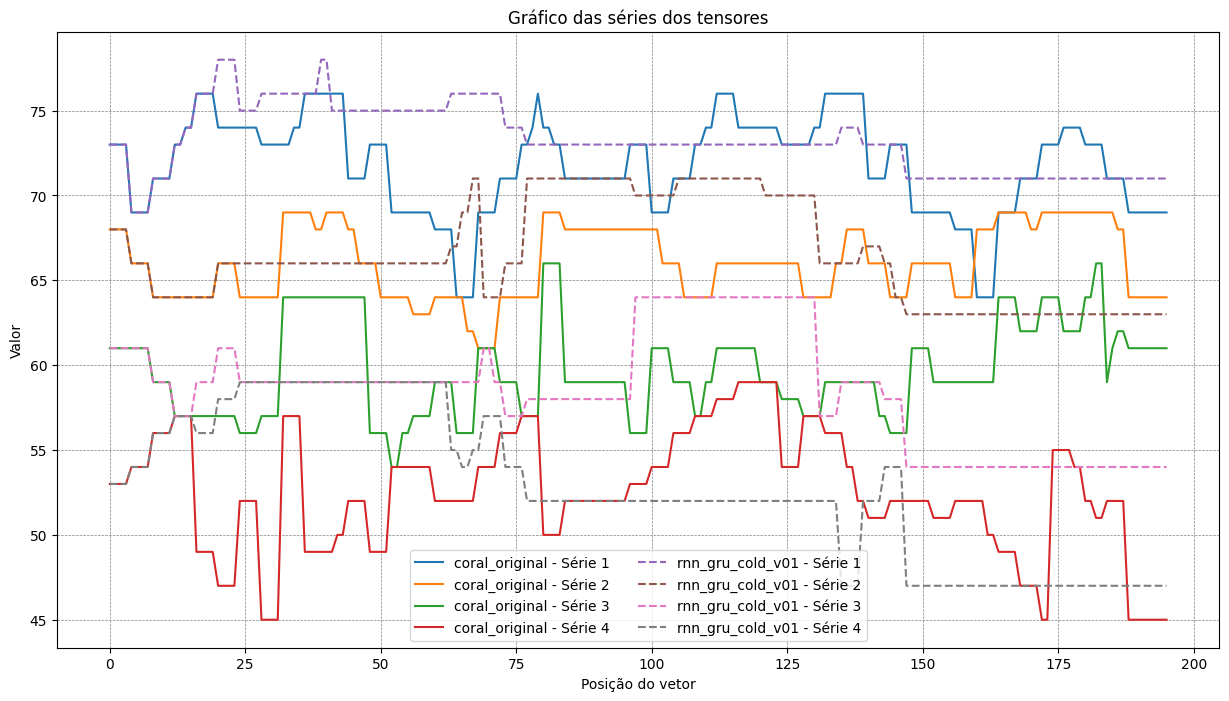

In [ ]:
# Tensores
coral_original = tf.cast(test_chorales[2], tf.int32)
rnn_gru_cold_v01 = tf.cast(new_chorale_v2_cold_gru_v01, tf.int32)

# Converter para numpy array
data1 = coral_original.numpy()
data2 = rnn_gru_cold_v01.numpy()

# Ajustar o tamanho da figura
plt.figure(figsize=(15, 8))

# Plotar cada série (coluna) do primeiro tensor
for i in range(data1.shape[1]):
    plt.plot(data1[:, i], linestyle='-', label=f'coral_original - Série {i+1}')

# Plotar cada série (coluna) do segundo tensor com um estilo diferente
for i in range(data2.shape[1]):
    plt.plot(data2[:, i], linestyle='--', label=f'rnn_gru_cold_v01 - Série {i+1}')

plt.xlabel('Posição do vetor')
plt.ylabel('Valor')
plt.title('Gráfico das séries dos tensores')
plt.legend(ncol=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

#### Transformer v.01

In [ ]:
new_chorale_v2_cold_t_v01 = generate_chorale_v2(model_t_v01, seed_chords, 100, temperature=temp_conservador)
play_chords(new_chorale_v2_cold_t_v01, filepath="bach_cold_t_v01.wav")

Output hidden; open in https://colab.research.google.com to view.

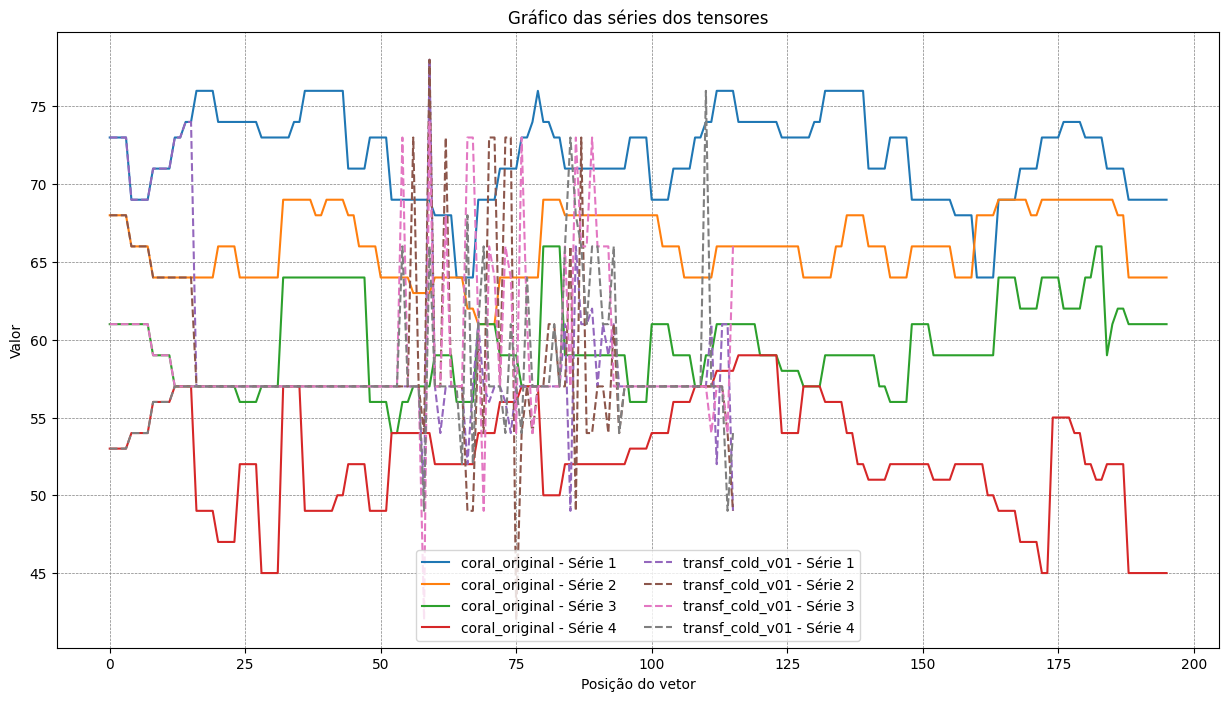

In [ ]:
# Tensores
coral_original = tf.cast(test_chorales[2], tf.int32)
transf_cold_v01 = tf.cast(new_chorale_v2_cold_t_v01, tf.int32)

# Converter para numpy array
data1 = coral_original.numpy()
data2 = transf_cold_v01.numpy()

# Ajustar o tamanho da figura
plt.figure(figsize=(15, 8))

# Plotar cada série (coluna) do primeiro tensor
for i in range(data1.shape[1]):
    plt.plot(data1[:, i], linestyle='-', label=f'coral_original - Série {i+1}')

# Plotar cada série (coluna) do segundo tensor com um estilo diferente
for i in range(data2.shape[1]):
    plt.plot(data2[:, i], linestyle='--', label=f'transf_cold_v01 - Série {i+1}')

plt.xlabel('Posição do vetor')
plt.ylabel('Valor')
plt.title('Gráfico das séries dos tensores')
plt.legend(ncol=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

### Nível moderado

In [ ]:
temp_moderado = 1

#### RNN v.01

In [ ]:
new_chorale_v2_cool_v01 = generate_chorale_v2(model_v01, seed_chords, 180, temperature=temp_moderado)
play_chords(new_chorale_v2_cool_v01, filepath="bach_cool_v01.wav")

Output hidden; open in https://colab.research.google.com to view.

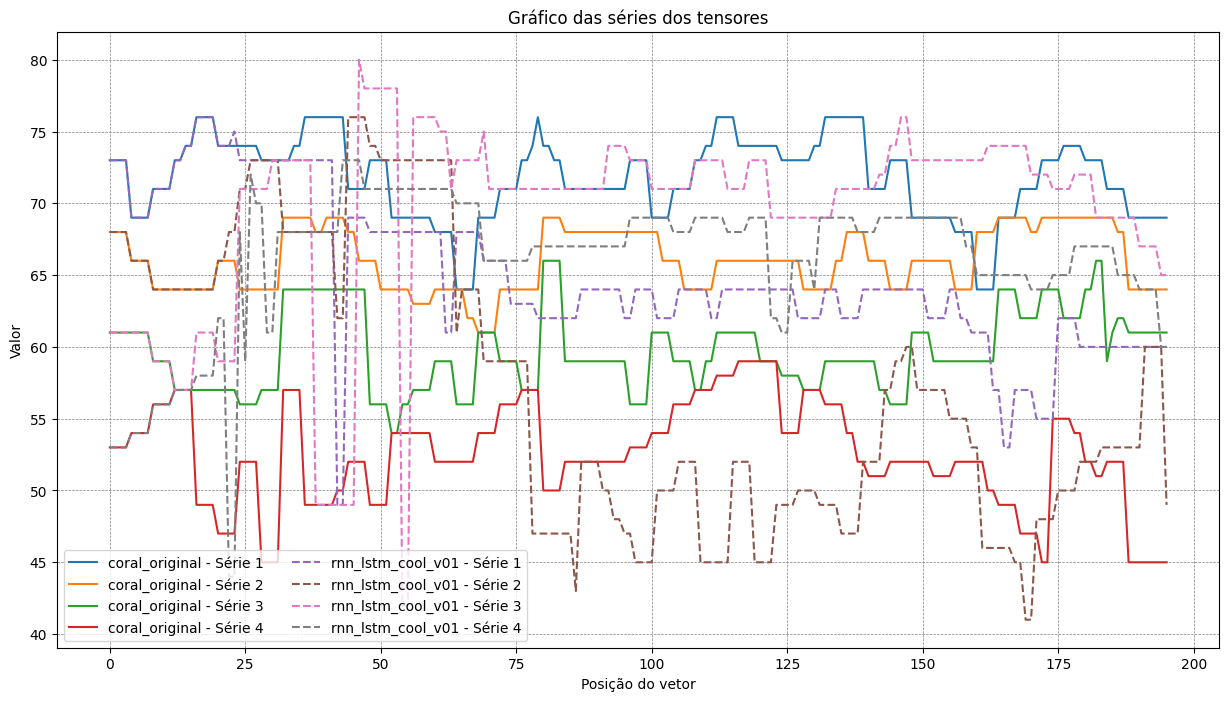

In [ ]:
# Tensores
coral_original = tf.cast(test_chorales[2], tf.int32)
rnn_lstm_cool_v01 = tf.cast(new_chorale_v2_cool_v01, tf.int32)

# Converter para numpy array
data1 = coral_original.numpy()
data2 = rnn_lstm_cool_v01.numpy()

# Ajustar o tamanho da figura
plt.figure(figsize=(15, 8))

# Plotar cada série (coluna) do primeiro tensor
for i in range(data1.shape[1]):
    plt.plot(data1[:, i], linestyle='-', label=f'coral_original - Série {i+1}')

# Plotar cada série (coluna) do segundo tensor com um estilo diferente
for i in range(data2.shape[1]):
    plt.plot(data2[:, i], linestyle='--', label=f'rnn_lstm_cool_v01 - Série {i+1}')

plt.xlabel('Posição do vetor')
plt.ylabel('Valor')
plt.title('Gráfico das séries dos tensores')
plt.legend(ncol=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

#### RNN v.02

In [ ]:
new_chorale_v2_cool_v02 = generate_chorale_v2(model_v02, seed_chords, 180, temperature=temp_moderado)
play_chords(new_chorale_v2_cool_v02, filepath="bach_cool_v02.wav")

Output hidden; open in https://colab.research.google.com to view.

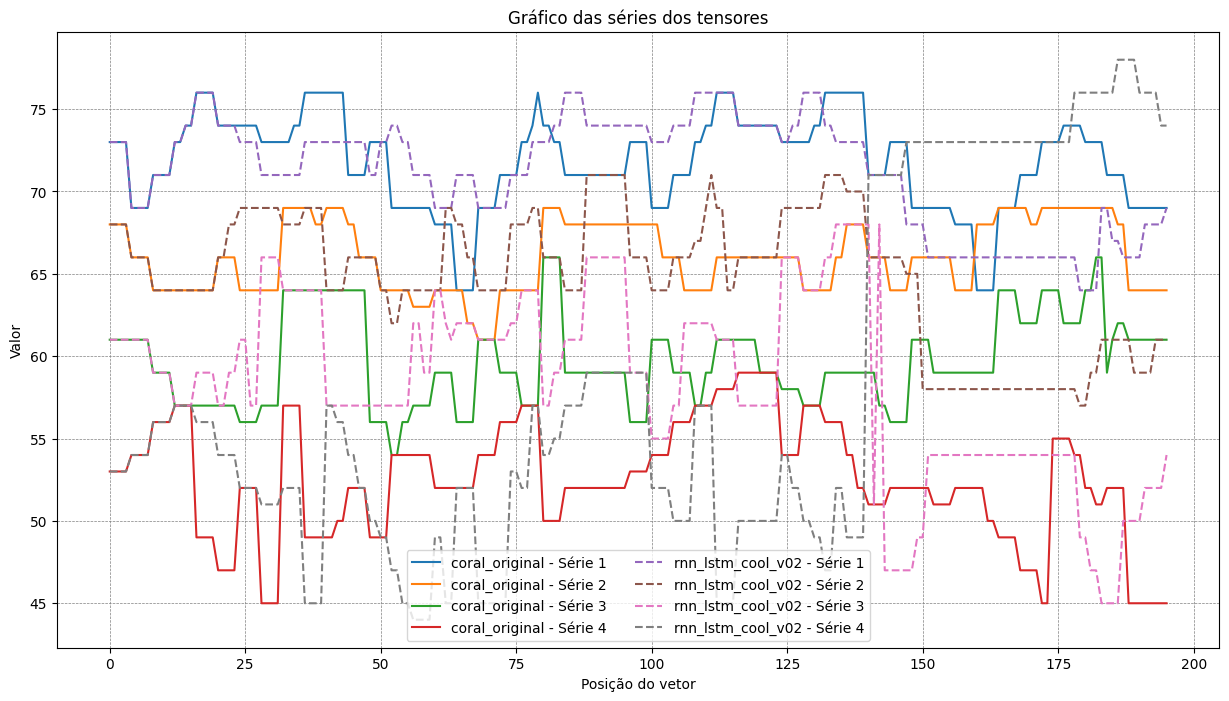

In [ ]:
# Tensores
coral_original = tf.cast(test_chorales[2], tf.int32)
rnn_lstm_cool_v02 = tf.cast(new_chorale_v2_cool_v02, tf.int32)

# Converter para numpy array
data1 = coral_original.numpy()
data2 = rnn_lstm_cool_v02.numpy()

# Ajustar o tamanho da figura
plt.figure(figsize=(15, 8))

# Plotar cada série (coluna) do primeiro tensor
for i in range(data1.shape[1]):
    plt.plot(data1[:, i], linestyle='-', label=f'coral_original - Série {i+1}')

# Plotar cada série (coluna) do segundo tensor com um estilo diferente
for i in range(data2.shape[1]):
    plt.plot(data2[:, i], linestyle='--', label=f'rnn_lstm_cool_v02 - Série {i+1}')

plt.xlabel('Posição do vetor')
plt.ylabel('Valor')
plt.title('Gráfico das séries dos tensores')
plt.legend(ncol=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

#### RNN v.03

In [ ]:
new_chorale_v2_cool_v03 = generate_chorale_v2(model_v03, seed_chords, 180, temperature=temp_moderado)
play_chords(new_chorale_v2_cool_v03, filepath="bach_cool_v03.wav")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Tensores
coral_original = tf.cast(test_chorales[2], tf.int32)
rnn_lstm_cool_v03 = tf.cast(new_chorale_v2_cool_v03, tf.int32)

# Converter para numpy array
data1 = coral_original.numpy()
data2 = rnn_lstm_cool_v03.numpy()

# Ajustar o tamanho da figura
plt.figure(figsize=(15, 8))

# Plotar cada série (coluna) do primeiro tensor
for i in range(data1.shape[1]):
    plt.plot(data1[:, i], linestyle='-', label=f'coral_original - Série {i+1}')

# Plotar cada série (coluna) do segundo tensor com um estilo diferente
for i in range(data2.shape[1]):
    plt.plot(data2[:, i], linestyle='--', label=f'rnn_lstm_cool_v03 - Série {i+1}')

plt.xlabel('Posição do vetor')
plt.ylabel('Valor')
plt.title('Gráfico das séries dos tensores')
plt.legend(ncol=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

NameError: ignored

#### RNN v.04

In [ ]:
new_chorale_v2_cool_v04 = generate_chorale_v2(model_v04, seed_chords, 180, temperature=temp_moderado)
play_chords(new_chorale_v2_cool_v04, filepath="bach_cool_v04.wav")

NameError: ignored

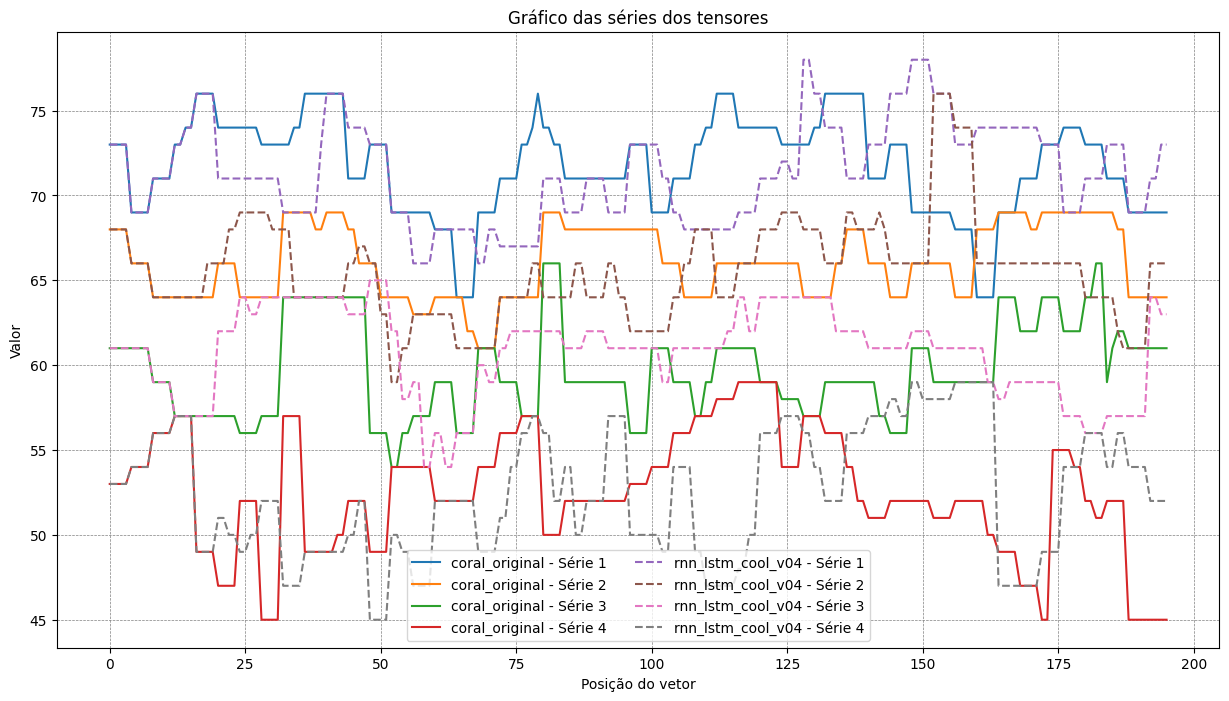

In [ ]:
# Tensores
coral_original = tf.cast(test_chorales[2], tf.int32)
rnn_lstm_cool_v04 = tf.cast(new_chorale_v2_cool_v04, tf.int32)

# Converter para numpy array
data1 = coral_original.numpy()
data2 = rnn_lstm_cool_v04.numpy()

# Ajustar o tamanho da figura
plt.figure(figsize=(15, 8))

# Plotar cada série (coluna) do primeiro tensor
for i in range(data1.shape[1]):
    plt.plot(data1[:, i], linestyle='-', label=f'coral_original - Série {i+1}')

# Plotar cada série (coluna) do segundo tensor com um estilo diferente
for i in range(data2.shape[1]):
    plt.plot(data2[:, i], linestyle='--', label=f'rnn_lstm_cool_v04 - Série {i+1}')

plt.xlabel('Posição do vetor')
plt.ylabel('Valor')
plt.title('Gráfico das séries dos tensores')
plt.legend(ncol=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

#### GRU v.01

In [ ]:
new_chorale_v2_cool_gru_v01 = generate_chorale_v2(model_gru_v01, seed_chords, 180, temperature=temp_conservador)
play_chords(new_chorale_v2_cool_gru_v01, filepath="bach_cool_gru_v01.wav")

Output hidden; open in https://colab.research.google.com to view.

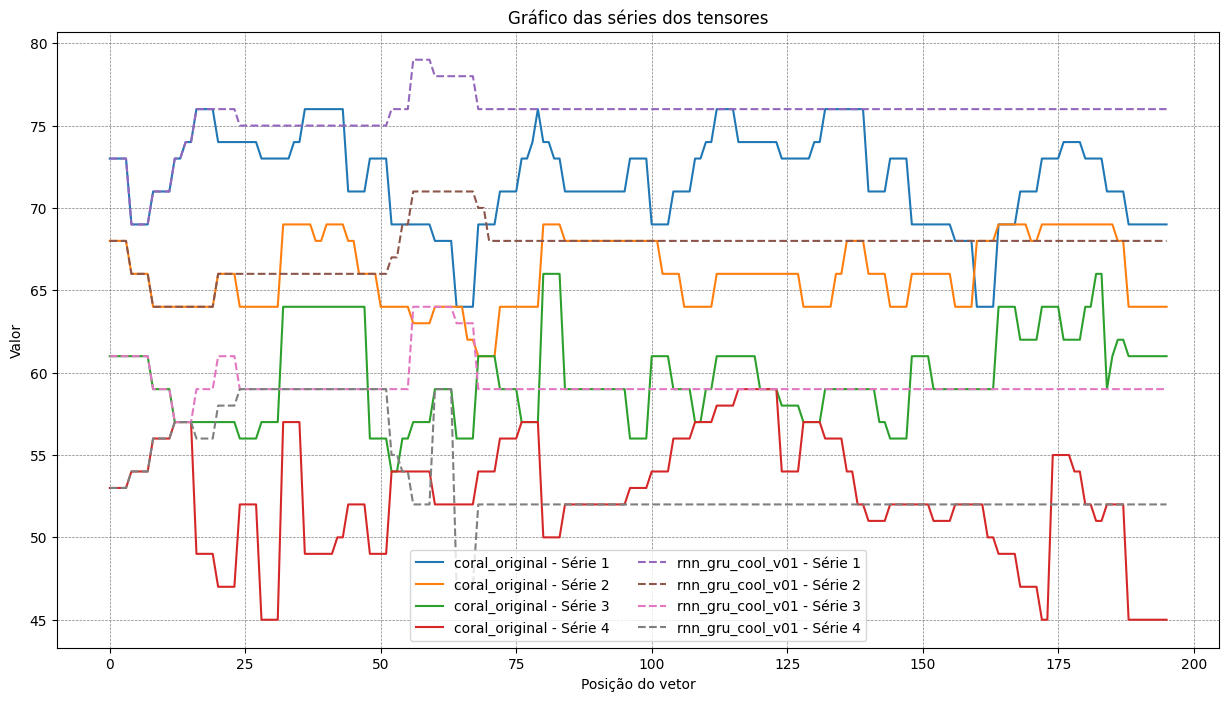

In [ ]:
# Tensores
coral_original = tf.cast(test_chorales[2], tf.int32)
rnn_gru_cool_v01 = tf.cast(new_chorale_v2_cool_gru_v01, tf.int32)

# Converter para numpy array
data1 = coral_original.numpy()
data2 = rnn_gru_cool_v01.numpy()

# Ajustar o tamanho da figura
plt.figure(figsize=(15, 8))

# Plotar cada série (coluna) do primeiro tensor
for i in range(data1.shape[1]):
    plt.plot(data1[:, i], linestyle='-', label=f'coral_original - Série {i+1}')

# Plotar cada série (coluna) do segundo tensor com um estilo diferente
for i in range(data2.shape[1]):
    plt.plot(data2[:, i], linestyle='--', label=f'rnn_gru_cool_v01 - Série {i+1}')

plt.xlabel('Posição do vetor')
plt.ylabel('Valor')
plt.title('Gráfico das séries dos tensores')
plt.legend(ncol=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

#### Transformer v.01

In [ ]:
new_chorale_v2_cool_t_v01 = generate_chorale_v2(model_t_v01, seed_chords, 100, temperature=temp_conservador)
play_chords(new_chorale_v2_cool_t_v01, filepath="bach_cool_t_v01.wav")

Output hidden; open in https://colab.research.google.com to view.

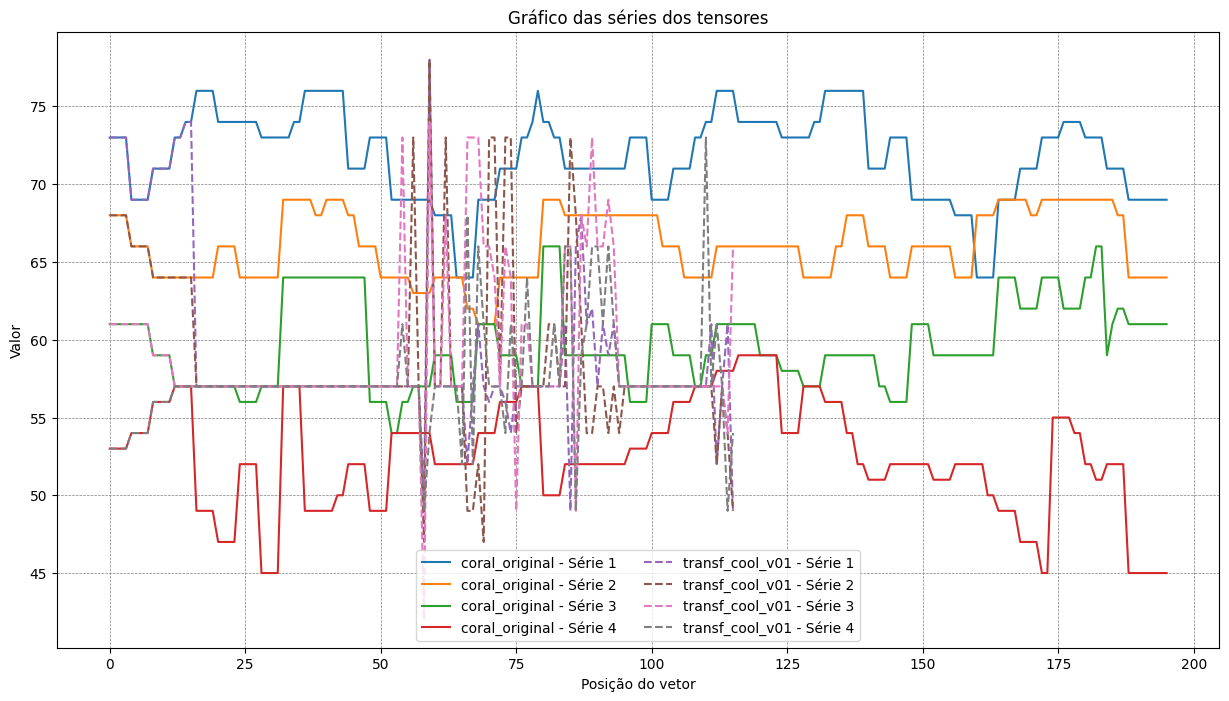

In [ ]:
# Tensores
coral_original = tf.cast(test_chorales[2], tf.int32)
transf_cool_v01 = tf.cast(new_chorale_v2_cool_t_v01, tf.int32)

# Converter para numpy array
data1 = coral_original.numpy()
data2 = transf_cool_v01.numpy()

# Ajustar o tamanho da figura
plt.figure(figsize=(15, 8))

# Plotar cada série (coluna) do primeiro tensor
for i in range(data1.shape[1]):
    plt.plot(data1[:, i], linestyle='-', label=f'coral_original - Série {i+1}')

# Plotar cada série (coluna) do segundo tensor com um estilo diferente
for i in range(data2.shape[1]):
    plt.plot(data2[:, i], linestyle='--', label=f'transf_cool_v01 - Série {i+1}')

plt.xlabel('Posição do vetor')
plt.ylabel('Valor')
plt.title('Gráfico das séries dos tensores')
plt.legend(ncol=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

### Nível hardcore

In [ ]:
temp_hardcore = 2.5

#### RNN v.01

In [ ]:
new_chorale_v2_hot_v01 = generate_chorale_v2(model_v01, seed_chords, 180, temperature=temp_hardcore)
play_chords(new_chorale_v2_hot_v01, filepath="bach_hot_v01.wav")

Output hidden; open in https://colab.research.google.com to view.

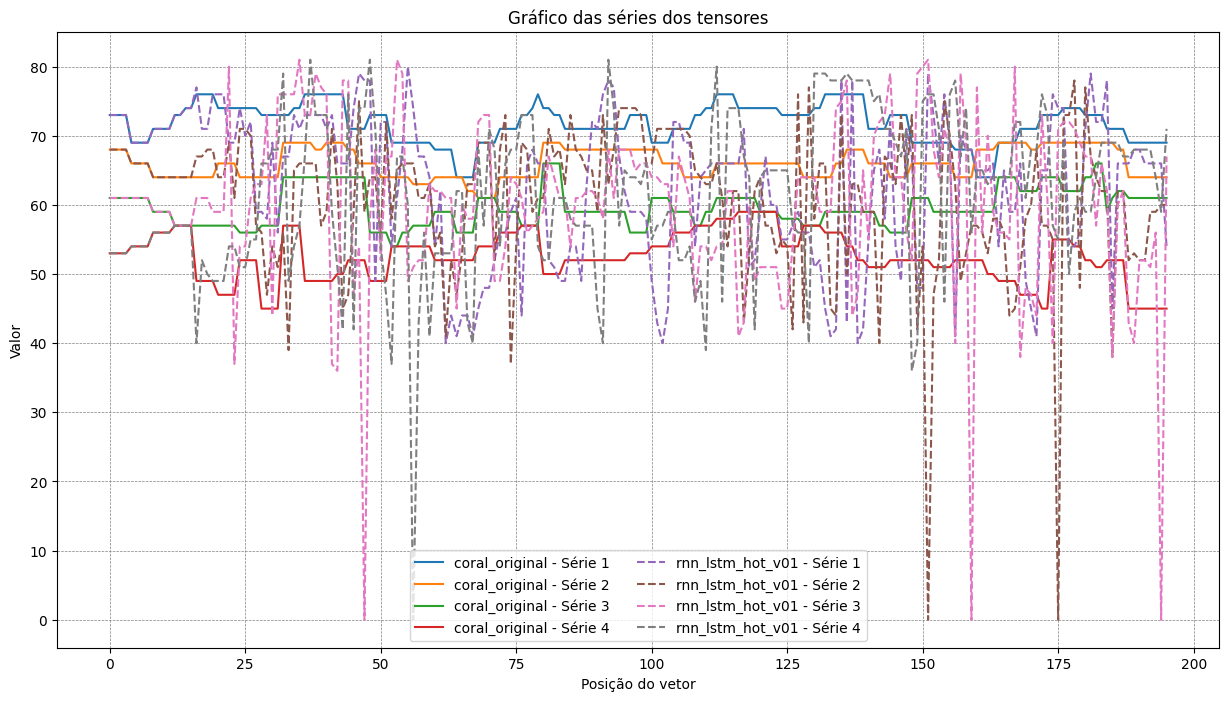

In [ ]:
# Tensores
coral_original = tf.cast(test_chorales[2], tf.int32)
rnn_lstm_hot_v01 = tf.cast(new_chorale_v2_hot_v01, tf.int32)

# Converter para numpy array
data1 = coral_original.numpy()
data2 = rnn_lstm_hot_v01.numpy()

# Ajustar o tamanho da figura
plt.figure(figsize=(15, 8))

# Plotar cada série (coluna) do primeiro tensor
for i in range(data1.shape[1]):
    plt.plot(data1[:, i], linestyle='-', label=f'coral_original - Série {i+1}')

# Plotar cada série (coluna) do segundo tensor com um estilo diferente
for i in range(data2.shape[1]):
    plt.plot(data2[:, i], linestyle='--', label=f'rnn_lstm_hot_v01 - Série {i+1}')

plt.xlabel('Posição do vetor')
plt.ylabel('Valor')
plt.title('Gráfico das séries dos tensores')
plt.legend(ncol=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

#### RNN v.02

In [ ]:
new_chorale_v2_hot_v02 = generate_chorale_v2(model_v02, seed_chords, 180, temperature=temp_hardcore)
play_chords(new_chorale_v2_hot_v02, filepath="bach_hot_v02.wav")

Output hidden; open in https://colab.research.google.com to view.

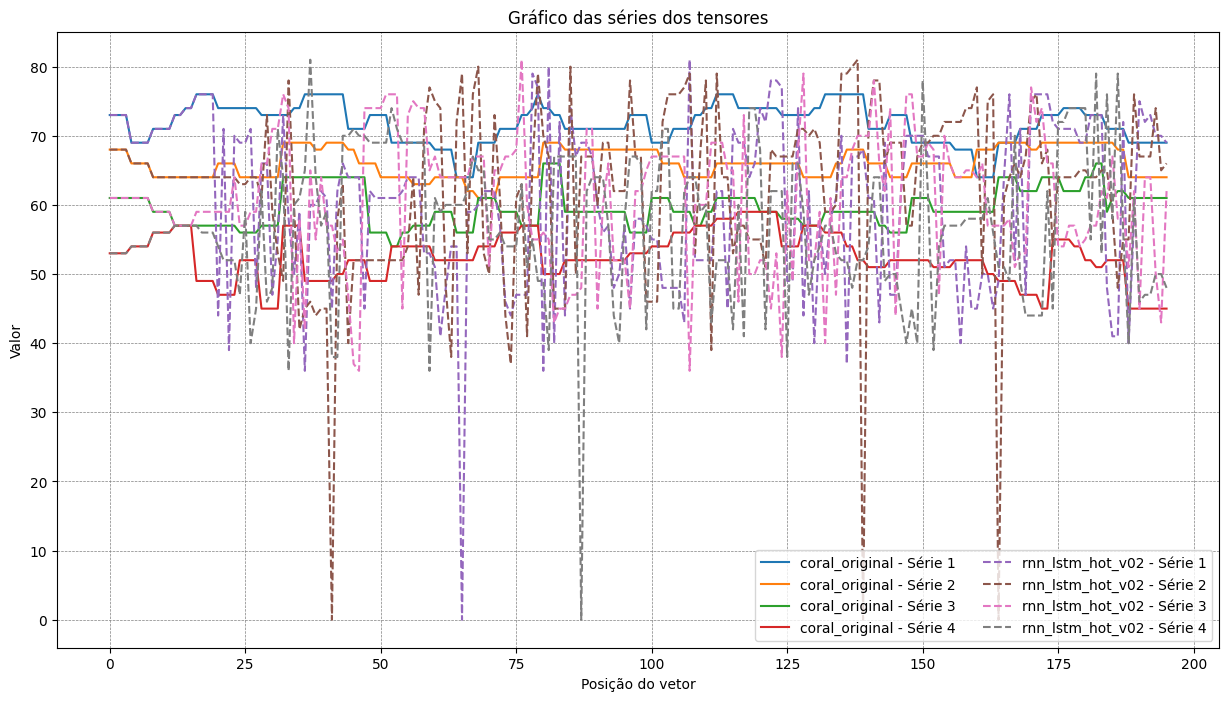

In [ ]:
# Tensores
coral_original = tf.cast(test_chorales[2], tf.int32)
rnn_lstm_hot_v02 = tf.cast(new_chorale_v2_hot_v02, tf.int32)

# Converter para numpy array
data1 = coral_original.numpy()
data2 = rnn_lstm_hot_v02.numpy()

# Ajustar o tamanho da figura
plt.figure(figsize=(15, 8))

# Plotar cada série (coluna) do primeiro tensor
for i in range(data1.shape[1]):
    plt.plot(data1[:, i], linestyle='-', label=f'coral_original - Série {i+1}')

# Plotar cada série (coluna) do segundo tensor com um estilo diferente
for i in range(data2.shape[1]):
    plt.plot(data2[:, i], linestyle='--', label=f'rnn_lstm_hot_v02 - Série {i+1}')

plt.xlabel('Posição do vetor')
plt.ylabel('Valor')
plt.title('Gráfico das séries dos tensores')
plt.legend(ncol=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

#### RNN v.03

In [ ]:
new_chorale_v2_hot_v03 = generate_chorale_v2(model_v03, seed_chords, 180, temperature=temp_hardcore)
play_chords(new_chorale_v2_hot_v03, filepath="bach_hot_v03.wav")

Output hidden; open in https://colab.research.google.com to view.

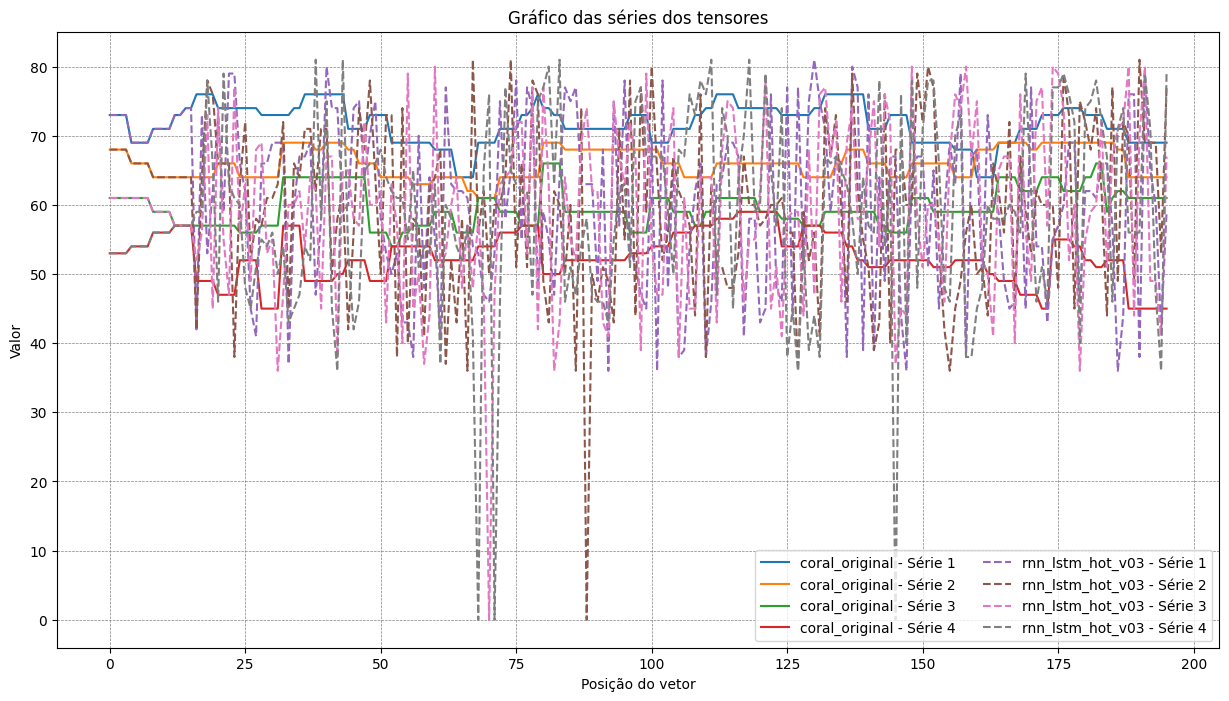

In [ ]:
# Tensores
coral_original = tf.cast(test_chorales[2], tf.int32)
rnn_lstm_hot_v03 = tf.cast(new_chorale_v2_hot_v03, tf.int32)

# Converter para numpy array
data1 = coral_original.numpy()
data2 = rnn_lstm_hot_v03.numpy()

# Ajustar o tamanho da figura
plt.figure(figsize=(15, 8))

# Plotar cada série (coluna) do primeiro tensor
for i in range(data1.shape[1]):
    plt.plot(data1[:, i], linestyle='-', label=f'coral_original - Série {i+1}')

# Plotar cada série (coluna) do segundo tensor com um estilo diferente
for i in range(data2.shape[1]):
    plt.plot(data2[:, i], linestyle='--', label=f'rnn_lstm_hot_v03 - Série {i+1}')

plt.xlabel('Posição do vetor')
plt.ylabel('Valor')
plt.title('Gráfico das séries dos tensores')
plt.legend(ncol=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

#### RNN v.04

In [ ]:
new_chorale_v2_hot_v04 = generate_chorale_v2(model_v04, seed_chords, 180, temperature=temp_hardcore)
play_chords(new_chorale_v2_hot_v04, filepath="bach_hot_v04.wav")

Output hidden; open in https://colab.research.google.com to view.

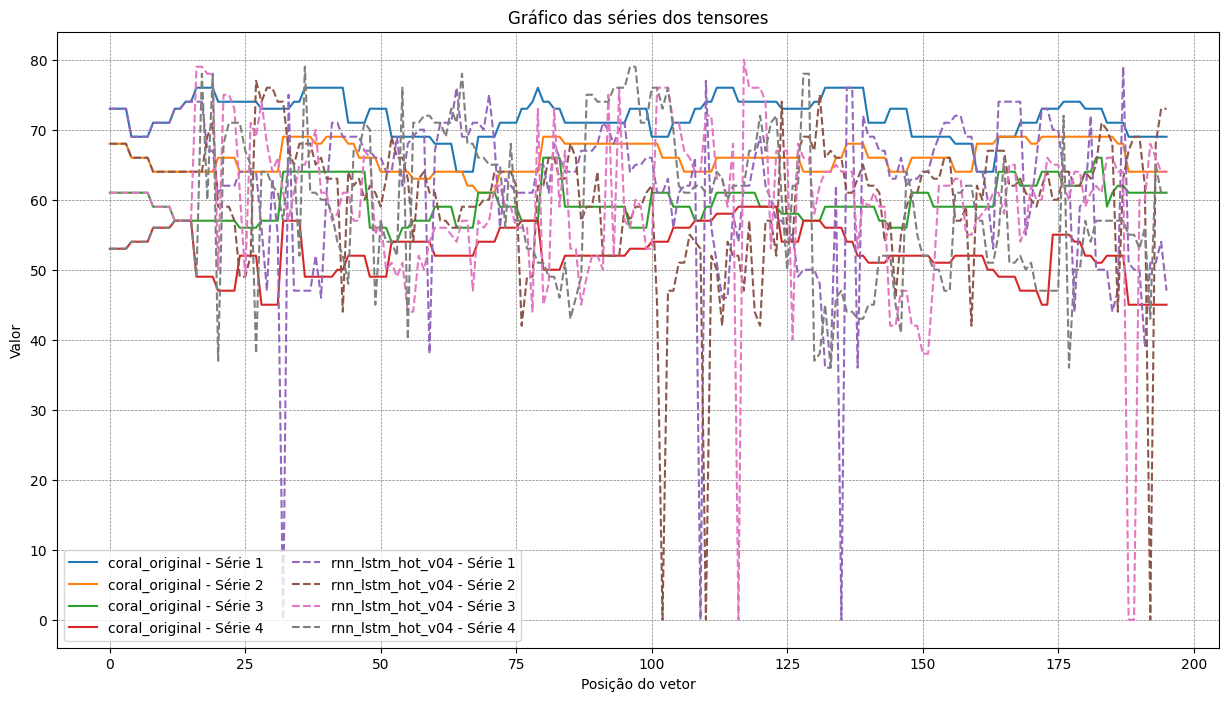

In [ ]:
# Tensores
coral_original = tf.cast(test_chorales[2], tf.int32)
rnn_lstm_hot_v04 = tf.cast(new_chorale_v2_hot_v04, tf.int32)

# Converter para numpy array
data1 = coral_original.numpy()
data2 = rnn_lstm_hot_v04.numpy()

# Ajustar o tamanho da figura
plt.figure(figsize=(15, 8))

# Plotar cada série (coluna) do primeiro tensor
for i in range(data1.shape[1]):
    plt.plot(data1[:, i], linestyle='-', label=f'coral_original - Série {i+1}')

# Plotar cada série (coluna) do segundo tensor com um estilo diferente
for i in range(data2.shape[1]):
    plt.plot(data2[:, i], linestyle='--', label=f'rnn_lstm_hot_v04 - Série {i+1}')

plt.xlabel('Posição do vetor')
plt.ylabel('Valor')
plt.title('Gráfico das séries dos tensores')
plt.legend(ncol=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

#### GRU v.01

In [ ]:
new_chorale_v2_hot_gru_v01 = generate_chorale_v2(model_gru_v01, seed_chords, 180, temperature=temp_hardcore)
play_chords(new_chorale_v2_hot_gru_v01, filepath="bach_hot_gru_v01.wav")

Output hidden; open in https://colab.research.google.com to view.

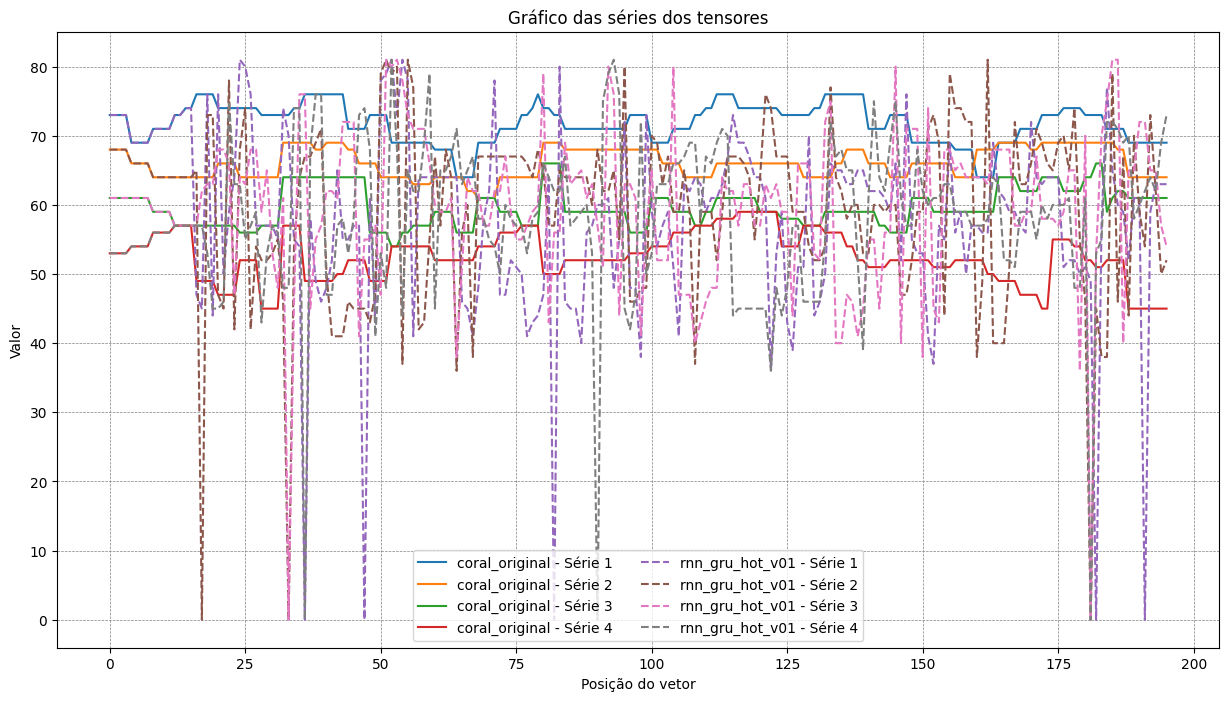

In [ ]:
# Tensores
coral_original = tf.cast(test_chorales[2], tf.int32)
rnn_gru_hot_v01 = tf.cast(new_chorale_v2_hot_gru_v01, tf.int32)

# Converter para numpy array
data1 = coral_original.numpy()
data2 = rnn_gru_hot_v01.numpy()

# Ajustar o tamanho da figura
plt.figure(figsize=(15, 8))

# Plotar cada série (coluna) do primeiro tensor
for i in range(data1.shape[1]):
    plt.plot(data1[:, i], linestyle='-', label=f'coral_original - Série {i+1}')

# Plotar cada série (coluna) do segundo tensor com um estilo diferente
for i in range(data2.shape[1]):
    plt.plot(data2[:, i], linestyle='--', label=f'rnn_gru_hot_v01 - Série {i+1}')

plt.xlabel('Posição do vetor')
plt.ylabel('Valor')
plt.title('Gráfico das séries dos tensores')
plt.legend(ncol=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

#### Transformer v.01

In [ ]:
new_chorale_v2_hot_t_v01 = generate_chorale_v2(model_t_v01, seed_chords, 100, temperature=temp_hardcore)
play_chords(new_chorale_v2_hot_t_v01, filepath="bach_hot_t_v01.wav")

NameError: ignored

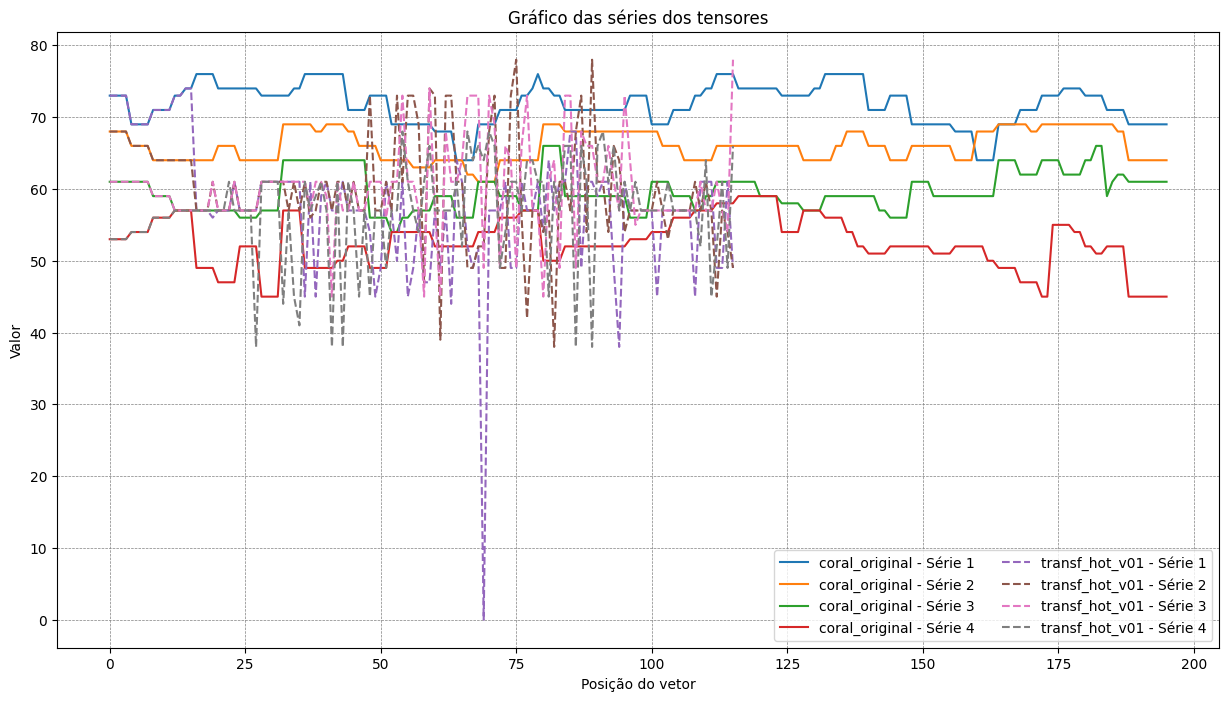

In [ ]:
# Tensores
coral_original = tf.cast(test_chorales[2], tf.int32)
transf_hot_v01 = tf.cast(new_chorale_v2_hot_t_v01, tf.int32)

# Converter para numpy array
data1 = coral_original.numpy()
data2 = transf_hot_v01.numpy()

# Ajustar o tamanho da figura
plt.figure(figsize=(15, 8))

# Plotar cada série (coluna) do primeiro tensor
for i in range(data1.shape[1]):
    plt.plot(data1[:, i], linestyle='-', label=f'coral_original - Série {i+1}')

# Plotar cada série (coluna) do segundo tensor com um estilo diferente
for i in range(data2.shape[1]):
    plt.plot(data2[:, i], linestyle='--', label=f'transf_hot_v01 - Série {i+1}')

plt.xlabel('Posição do vetor')
plt.ylabel('Valor')
plt.title('Gráfico das séries dos tensores')
plt.legend(ncol=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

xxxxxxxx

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten


In [ ]:
from keras.layers import Dropout
from keras.optimizers import Adam

def build_generator():
    model = Sequential()
    # Supondo que estamos começando com um vetor latente de 100
    model.add(Dense(128, input_dim=100))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(np.prod([4]), activation='tanh'))  # Suponha que 4 seja o tamanho da saída (como 4 notas)
    return model

def build_discriminator():
    model = Sequential()
    model.add(Dense(512, input_dim=4))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Dense(128))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Dense(1, activation='sigmoid'))
    return model

optimizer = Adam(lr=0.0002, beta_1=0.5)


In [ ]:
def build_gan(generator, discriminator, latent_dim=100):
    discriminator.trainable = False
    gan_input = keras.layers.Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = keras.models.Model(gan_input, gan_output)
    return gan

generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

In [ ]:
def generate_music(generator, latent_dim, temperature=1):
    noise = np.random.normal(0, 1, (1, latent_dim))
    generated_chords = generator.predict(noise)
    # Supondo que 'model' é algum modelo anterior que você usou para a geração
    return generate_chorale_v2(model, generated_chords, 56, temperature=temperature)


In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# Treine o modelo usando: model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping])


In [ ]:
discriminator.compile(optimizer=keras.optimizers.Adam(0.0002, 0.5),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

gan.compile(optimizer=keras.optimizers.Adam(0.0002, 0.5), loss='binary_crossentropy')

In [ ]:
def train_gan(gan, generator, discriminator, dataset, epochs, batch_size=128, latent_dim=100):
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # Treinando o discriminador
        real_data_list = [instance[0].numpy() for instance in next(iter(dataset.take(batch_size)))]

        # Se a quantidade de real_data não for igual ao batch_size, pule esta época
        if len(real_data_list) != batch_size:
            continue

        real_data = np.array(real_data_list)
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        generated_data = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_data, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Treinando o gerador
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, real_labels)

        print(f"Epoch: {epoch + 1}, D Loss Real: {d_loss_real[0]}, D Loss Fake: {d_loss_fake[0]}, G Loss: {g_loss}")

    return generator


XXXXXXXX

In [ ]:
import numpy as np
from keras.layers import Dense, Reshape, Flatten, Input, LeakyReLU, Dropout
from keras.models import Sequential, Model
from keras.optimizers import Adam

latent_dim = 100  # Dimensão do vetor latente

def build_generator():
    model = Sequential()

    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(0.2))

    model.add(Dense(512))
    model.add(LeakyReLU(0.2))

    model.add(Dense(1024))
    model.add(LeakyReLU(0.2))

    model.add(Dense(4, activation='sigmoid'))  # Quatro saídas que representam as 4 notas do acorde
    model.add(Reshape((-1,)))

    noise = Input(shape=(latent_dim,))
    chord = model(noise)

    # Mapeamos para o intervalo [36, 72]
    mapped_chord = 36 + chord * (72 - 36)

    return Model(noise, mapped_chord)

def build_discriminator():
    model = Sequential()

    model.add(Dense(512, input_dim=4))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Dense(128))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Dense(1, activation='sigmoid'))

    chords = Input(shape=(4,))
    validity = model(chords)

    return Model(chords, validity)

def build_gan(generator, discriminator):
    discriminator.trainable = False

    noise = Input(shape=(latent_dim,))
    chords = generator(noise)
    validity = discriminator(chords)

    return Model(noise, validity)

# Construindo a GAN
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Agora você pode continuar com a função de treinamento e treinar sua GAN.
# Após treinamento, você pode gerar acordes usando o gerador, como foi mostrado anteriormente.


In [ ]:
trained_generator = train_gan(gan, generator, discriminator, train_set, epochs=5000, batch_size=128)

In [ ]:
def generate_chorale_gan(generator, seed_chords, length, latent_dim=100):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])

    for chord in range(length):
        noise = np.random.normal(0, 1, (1, latent_dim))
        generated_notes = generator.predict(noise)
        # Adapte a próxima linha conforme necessário para formatar a saída gerada
        generated_notes = np.round(generated_notes * 127).astype(int)  # converta para intervalo MIDI se a saída estiver entre 0 e 1
        arpegio = tf.concat([arpegio, tf.constant(generated_notes, dtype=tf.int64)], axis=1)

    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])


In [ ]:
generated_chords = generate_chorale_gan(trained_generator, seed_chords, length=20)

In [ ]:
print(generated_chords)


In [ ]:
play_chords(generated_chords)

#Referências